# Прогнозирование температуры звезды

![The color of Stars](https://sciencenotes.org/wp-content/uploads/2022/04/The-Colors-of-Stars-From-Hottest-to-Coldest.png)

Источник [sciencenotes.org](https://sciencenotes.org/the-colors-of-the-stars-from-hottest-to-coldest/)

## Введение

Цветовая классификация звезд https://sciencenotes.org/the-colors-of-the-stars-from-hottest-to-coldest/

Закзачик — обсерватория «Небо на ладони» — хочет перейти на технологии машинного обучения для определения температуры поверхности звезд. 

Для поиска решения на основе нейронных сетей заказчик предоставил харасктеристики и значения температуры 240 звезд. Характеристики данных следующие:
1. Относительная светимость $L/L_o$ — светимость звезды относительно Солнца.
1. Относительный радиус $R/R_o$ — радиус звезды относительно радиуса Солнца.
1. Абсолютная звёздная величина $M_v$ — физическая величина, характеризующая блеск звезды.
1. Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
1. Тип звезды:
    - 0 — Коричневый карлик
    - 1 — Красный карлик
    - 2 — Белый карлик
    - 3 — Звёзды главной последовательности
    - 4 — Сверхгигант
    - 5 — Гипергигант
1. Абсолютная температура $T(K)$ — температура на поверхности звезды в Кельвинах. 

Заказчик ожидает, что разработанная модель будет иметь RMSE не более 4500.

Заказчик просит включит в отчет график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

### Цель проекта

Целью проекта является разработка архитектуры и обучение модели, предсказывающей температуру поверхности звезды. 

Качество модели оценивается метрикой среднеквадратичная ошибка (RMSE) и должно быть меньше или равно 4500.

### Основные этапы

В проекты выполнены следующие основные этапы:
- исследовательский анализ данных,
- разработка базовой модели,
- улучшение модели.

### Выводы

Мы разработали модель, позволяющую определять температуру звезды по 5 характеристикам. Среднквадратичная ошибка предсказания на тестовых данных 2000.



## Подготовка кода

### Загрузка библиотек

In [1]:
from os import path
from functools import partial
from math import ceil
import numpy as np
import pandas as pd

In [88]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [4]:
import torch
import torch.nn as nn

/Volumes/T7/working/yp14-torch-nn-refression/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
from dotenv import load_dotenv
import neptune.new as neptune

### Инициализация

Констнаты

In [6]:
RANDOM_STATE = np.random.RandomState(257515) 
torch.manual_seed(257515)
torch.use_deterministic_algorithms(True)

Иницализация трекинга

In [7]:
load_dotenv()
PROJECT = os.getenv("PROJECT")
API_TOKEN = os.getenv("API_TOKEN")
PROJECT

'dimds/yp14-nn-regression'

### Функции и классы

#### normalize_color_values

In [8]:
def normalize_color_values(color: str) -> str:
    """Приводит значение цвета к форме: нижний регистр через пробел без"""
    
    return " ".join([_.strip() for _ in color.lower().replace("-", " ").split()])

#### reduce_color_values

In [9]:
def reduce_color_values(reduction_dict: dict, color: str) -> str:
    """Заменяет значение цвета на значение из словаря, либо возвращает исходное значение"""
    
    return reduction_dict[color] if color in reduction_dict else color

#### calc_vif

Основано на решении [steven](https://stackoverflow.com/a/54857466) @ stackoverflow, рассчитывает фактор инфляции дисперсии $ \mathit{VIF} = \frac{1}{1 - R^2}$ и толерантность $T = 1 - R$

In [10]:
def calc_vif(exogs: list, data: pd.DataFrame) -> pd.DataFrame:
    """Рассчитывает фактор инфляции дисперсии и толерантность для признаков exogs"""

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

#### make_run

In [11]:
def make_run(params: dict):
    """Creates Neptune Run"""
    
    run = neptune.init_run(
        project=PROJECT,
        api_token=API_TOKEN,
    )
    run["parameters"] = params
    return run

#### run_experiment

In [12]:
def run_experiment(_model):
    """Trains model with logging to Neptune"""
    run = make_run(_model.params)
    _model.fit(X_train_t, y_train_t, X_valid_t, y_valid_t, run)
    run.stop()  
    return _model

#### StarNet

In [13]:
class StarNet(nn.Module):
    def __init__(self,
                 n_in_neurons,
                 hidden_neurons,
                 n_out_neurons,
                 params,
                 verbose=True):
        super().__init__()

        assert params.get(
            "batch_size") is not None, "Missing batch_size in params"
        assert params.get(
            "learning_rate") is not None, "Missing learning_rate in params"
        assert params.get("n_epochs") is not None, "Missing n_epochs in params"

        self.params = params.copy()
        self.verbose = verbose
        self.rmse_min = np.Inf
        self.best_epoch = None

        # add params for logging
        self.params["n_neurons_in_layers"] = [
            n_in_neurons
        ] + hidden_neurons + [n_out_neurons]
        self.params["dims"] = n_in_neurons

        if params.get("model_name") is None:
            self.params["model_name"] = "StarNet"

        self._create_architecture(n_in_neurons, hidden_neurons, n_out_neurons)

        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.params["learning_rate"])

    def _create_architecture(self, n_in_neurons, hidden_neurons,
                             n_out_neurons):
        assert len(
            hidden_neurons
        ) == 2, f"Expect 2 elements in hidden_neurons but {len(hidden_neurons)} was given"

        # layers
        self.fc1 = nn.Linear(n_in_neurons, hidden_neurons[0])
        self.af1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        self.af2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_neurons[1], n_out_neurons)

    def forward(self, X):
        """Does forward run"""
        out = X
        for c in self.children():
            if not isinstance(c, nn.MSELoss):
                out = c(out)
        return out

    def fit(self, X_train, y_train, X_valid, y_valid, run=None):
        """Trains model on train data and validates on valid"""

        batch_size = self.params.get("batch_size")
        n_epochs = self.params.get("n_epochs")
        n_batches = ceil(len(X_train) / batch_size)
        step = n_epochs // 10

        for epoch in range(n_epochs):
            order = np.random.permutation(X_train.size()[0])
            for butch_idx in range(n_batches):
                start_idx = butch_idx * batch_size
                butch_idxs = order[start_idx:start_idx + batch_size]
                X_butch = X_train[butch_idxs]
                y_butch = y_train[butch_idxs]

                self.train()
                self.optimizer.zero_grad()
                preds = self.forward(X_butch)
                loss_value = self.loss(preds.flatten(), y_butch.flatten())
                loss_value.backward()
                self.optimizer.step()

            # epoch's results
            self.eval()
            preds_valid = self.forward(X_valid)
            valid_loss_value = self.loss(preds_valid.flatten(),
                                         y_valid.flatten())
            self.rmse_score = np.sqrt(valid_loss_value.detach().numpy())
            if self.rmse_score < self.rmse_min:
                self.rmse_min = self.rmse_score
                self.best_epoch = epoch

            if run is not None:
                run["train/loss"].log(loss_value)
                run["train/rmse"].log(np.sqrt(loss_value.detach().numpy()))
                run["evaluation/loss"].log(valid_loss_value)
                run["evaluation/rmse"].log(self.rmse_score)

            if self.verbose and (epoch % step == 0 or epoch == n_epochs - 1):
                print(
                    f"Epoch {epoch:5d} Loss train {loss_value:,.0f}\tvalid {valid_loss_value:,.0f}"
                )
        if self.verbose:
            print(f"Valid RMSE: {self.rmse_score:,.0f}")

    def predict(self, X):
        """Does predictions """
        self.eval()
        return self.forward(X)

#### StarNetWDO

In [14]:
class StarNetWDO(StarNet):
    def __init__(self, n_in_neurons, hidden_neurons, n_out_neurons, params, verbose=True):
        super().__init__(n_in_neurons, hidden_neurons, n_out_neurons, params, verbose)
        if params.get("model_name") is None:
            self.params["model_name"] = "StarNetWDO"

    def _create_architecture(self, n_in_neurons, hidden_neurons,
                             n_out_neurons):
        assert len(
            hidden_neurons
        ) == 2, f"Expect 2 elements in hidden_neurons but {len(hidden_neurons)} was given"
        
        dropout_proba = .0 if "dropout_proba" not in self.params else self.params["dropout_proba"]
        
        # layers
        self.fc1 = nn.Linear(n_in_neurons, hidden_neurons[0])
        self.af1 = nn.ReLU()
        self.do1 = nn.Dropout(p=dropout_proba)
        self.fc2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        self.af2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_neurons[1], n_out_neurons)

#### StarNetWBN

In [15]:
class StarNetWBN(StarNet):
    def __init__(self, n_in_neurons, hidden_neurons, n_out_neurons, params):
        super().__init__(n_in_neurons, hidden_neurons, n_out_neurons, params)
        if params.get("model_name") is None:
            self.params["model_name"] = "StarNetWBN"

    def _create_architecture(self, n_in_neurons, hidden_neurons, n_out_neurons):
        assert len(
            hidden_neurons
        ) == 2, f"Expect 2 elements in hidden_neurons but {len(hidden_neurons)} was given"
        
        # layers
        self.fc1 = nn.Linear(n_in_neurons, hidden_neurons[0])
        self.af1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_neurons[0])
        self.fc2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        self.af2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_neurons[1])
        self.fc3 = nn.Linear(hidden_neurons[1], n_out_neurons)

        # initialization
        if self.params.get("initialization") == "kaiming_uniform":
            nn.init.kaiming_uniform_(self.fc1.weight,
                                     mode='fan_in',
                                     nonlinearity='relu')
            nn.init.uniform_(self.fc1.bias, a=0, b=1)
            nn.init.kaiming_uniform_(self.fc2.weight,
                                     mode='fan_in',
                                     nonlinearity='relu')
            nn.init.uniform_(self.fc2.bias, a=0, b=1)
            nn.init.kaiming_uniform_(self.fc3.weight,
                                     mode='fan_in',
                                     nonlinearity='relu')
            nn.init.uniform_(self.fc3.bias, a=0, b=1)
            print("Initialized with kaiming_uniform")

        if self.params.get("initialization") == "uniform":
            nn.init.uniform_(self.fc1.weight, a=-1, b=1)
            nn.init.uniform_(self.fc1.bias, a=0, b=1)
            nn.init.uniform_(self.fc2.weight, a=0, b=1)
            nn.init.uniform_(self.fc2.bias, a=0, b=1)
            nn.init.uniform_(self.fc3.weight, a=-1, b=0)
            nn.init.uniform_(self.fc3.bias, a=0, b=1)
            print("Initialized with uniform")

#### StarNet4L

In [16]:
class StarNet4L(StarNet):
    def __init__(self, n_in_neurons, hidden_neurons, n_out_neurons, params):
        super().__init__(n_in_neurons, hidden_neurons, n_out_neurons, params)
        if params.get("model_name") is None:
            self.params["model_name"] = "StarNet4L"
    
    def _create_architecture(self, n_in_neurons, hidden_neurons,
                             n_out_neurons):
        assert len(
            hidden_neurons
        ) == 4, f"Expect 4 elements in hidden_neurons but {len(hidden_neurons)} was given"
        # layers
        self.fc1 = nn.Linear(n_in_neurons, hidden_neurons[0])
        self.bn1 = nn.BatchNorm1d(hidden_neurons[0])
        self.af1 = nn.Tanh()
        self.do1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        self.bn2 = nn.BatchNorm1d(hidden_neurons[1])
        self.af2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(hidden_neurons[1], hidden_neurons[2])
        self.bn3 = nn.BatchNorm1d(hidden_neurons[2])
        self.af3 = nn.Tanh()
        self.do3 = nn.Dropout(p=0.25)
        
        self.fc4 = nn.Linear(hidden_neurons[2], hidden_neurons[3])
        self.bn4 = nn.BatchNorm1d(hidden_neurons[3])
        self.af4 = nn.ReLU()
        self.do4 = nn.Dropout(p=0.25)
        
        self.fc5 = nn.Linear(hidden_neurons[3], n_out_neurons)    

## Загрузка данных

In [17]:
remote_path = 'https://code.s3.yandex.net/datasets/6_class.csv'
local_path = path.join('.', 'data', '6_class.csv')

if path.isfile(local_path):
    data = pd.read_csv(local_path, index_col=0)
else:
    data = pd.read_csv(remote_path, index_col=0)
    if path.exists(path.dirname(local_path)):
        data.to_csv(local_path)
        
data.shape

(240, 6)

Загружено 240 строк данных и 6 признаков.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [19]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Состав признаков и их значения соответствуют информации в задаче. 

Приведем названия признаков к snake-case.

In [20]:
data.columns = [
    'temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type',
    'star_color'
]

### Разделение данных

Будем придреживаться принципа, согласно которому мы не должны видеть тестовые данные до этапа тестирования моделей. Поэтому выделим данные для теста до исследовательского анализа. Для теста оставим 10% даных.

In [21]:
X = data.drop('temperature', axis=1)
y = data.temperature
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.15,
                                                    random_state=RANDOM_STATE)

In [22]:
X_train.shape, y_train.shape

((204, 5), (204,))

In [23]:
X_test.shape, y_test.shape

((36, 5), (36,))

Размер выборок корректный.

Сравним статистики целевого признака для обучающей и тестовой выборок.

In [24]:
y_train.describe()

count      204.000000
mean      9866.779412
std       9269.668902
min       1939.000000
25%       3336.000000
50%       5046.000000
75%      13039.500000
max      40000.000000
Name: temperature, dtype: float64

In [25]:
y_test.describe()

count       36.000000
mean     14071.333333
std      10453.135125
min       2700.000000
25%       3536.500000
50%      14541.000000
75%      22767.500000
max      38234.000000
Name: temperature, dtype: float64

Статистики целевого признака на обучающей и тестовой выборке похожи. Разделение данных выполнено корректно.

### Вывод

Мы загрузили полученные данные. Состав признаков и количество объектов соответствуют указанным в задаче. 

Из данных мы выделили 15% объектов для тестирования результатов. 

Исследовательский анализ, обучение и настройку моделей будем проводить на обучающей выборки, из которой выделим валидационную.

## Исследовательский анализ данных

Сделаем датасет для анализа на основе обучающей выборки.

In [26]:
df = X_train.join(y_train).copy()

### Структура данных

В нашем датасете 240 объектов, 5 призаков и один целевой признак.

#### Типы данных признаков

In [27]:
df.dtypes

luminosity            float64
radius                float64
absolute_magnitude    float64
star_type               int64
star_color             object
temperature             int64
dtype: object

Целевой признак целочисленный, 3 признака имеют вещественный тип, один — целый и один — строковый. Целым и строковым типами представлены категориальные признаки.

Выделим названия целевого, численных и категориальных признаков.

In [28]:
target_column = ["temperature"]
numerical_columns = ["luminosity", "radius", "absolute_magnitude"]
categorical_columns = ["star_type", "star_color"]

#### Количество уникальных значений

In [29]:
df.nunique()

luminosity            181
radius                183
absolute_magnitude    197
star_type               6
star_color             19
temperature           194
dtype: int64

Все числовые признаки имеют сотни значений, то есть являются непрерывными.

#### Статистики числовых признаков

In [30]:
df[numerical_columns + target_column].describe()

,luminosity,radius,absolute_magnitude,temperature
count,204.000000,204.000000,204.000000,204.000000
mean,99012.591707,228.158643,4.732858,9866.779412
std,170184.883481,509.767354,10.532762,9269.668902
min,0.000080,0.008700,-11.920000,1939.000000
25%,0.000755,0.099525,-6.146000,3336.000000
50%,0.021500,0.672500,10.260000,5046.000000
75%,184000.000000,36.000000,13.990000,13039.500000
max,849420.000000,1948.500000,20.060000,40000.000000


Минимальное значение `luminosity` 0.00008, максимальное — 849420. Разница в 11 порядков. Медиана 0.02, среднее — 101994. 

У остальных признаков также видим большую разницу между максимумом и минимумом и смещение медианы от среднего. 

В нашем датасете очень разные звезды, как и во вселенной.

#### Вывод



Мы изучили структуру данных. Убедились, что данные соответсвуют описанным в задаче. 

Мы видим, что звезды в датасете очень сильно отличаются друг от друга по характеристам и распределение значений скошено.

### Качество данных

#### Дубликаты

In [31]:
duplicates_number = df.duplicated().sum()
print(f'Нашли {duplicates_number} дубликатов в датасете.')

Нашли 0 дубликатов в датасете.


#### Пропуски

In [32]:
df.isna().sum()

luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
temperature           0
dtype: int64

Пропусков тоже нет.

#### Паттерны и ошибки заполнения

Проверим наш датасет на проблемы с заполнением числовых значений.

Для каждого числового признака построим график, который визуализирует значения признака (ось Y) для каждого из объектов в датасете (ось X).

Мы ожидаем, что распределение значений будет охватывать весь диапазон по оси Y для всех объектов, то есть на всем протяжении оси X.

Пробелы по оси X покажут ошибки заполнения значений, а визуальные паттерны будут говорить о характере заполнения датасета.

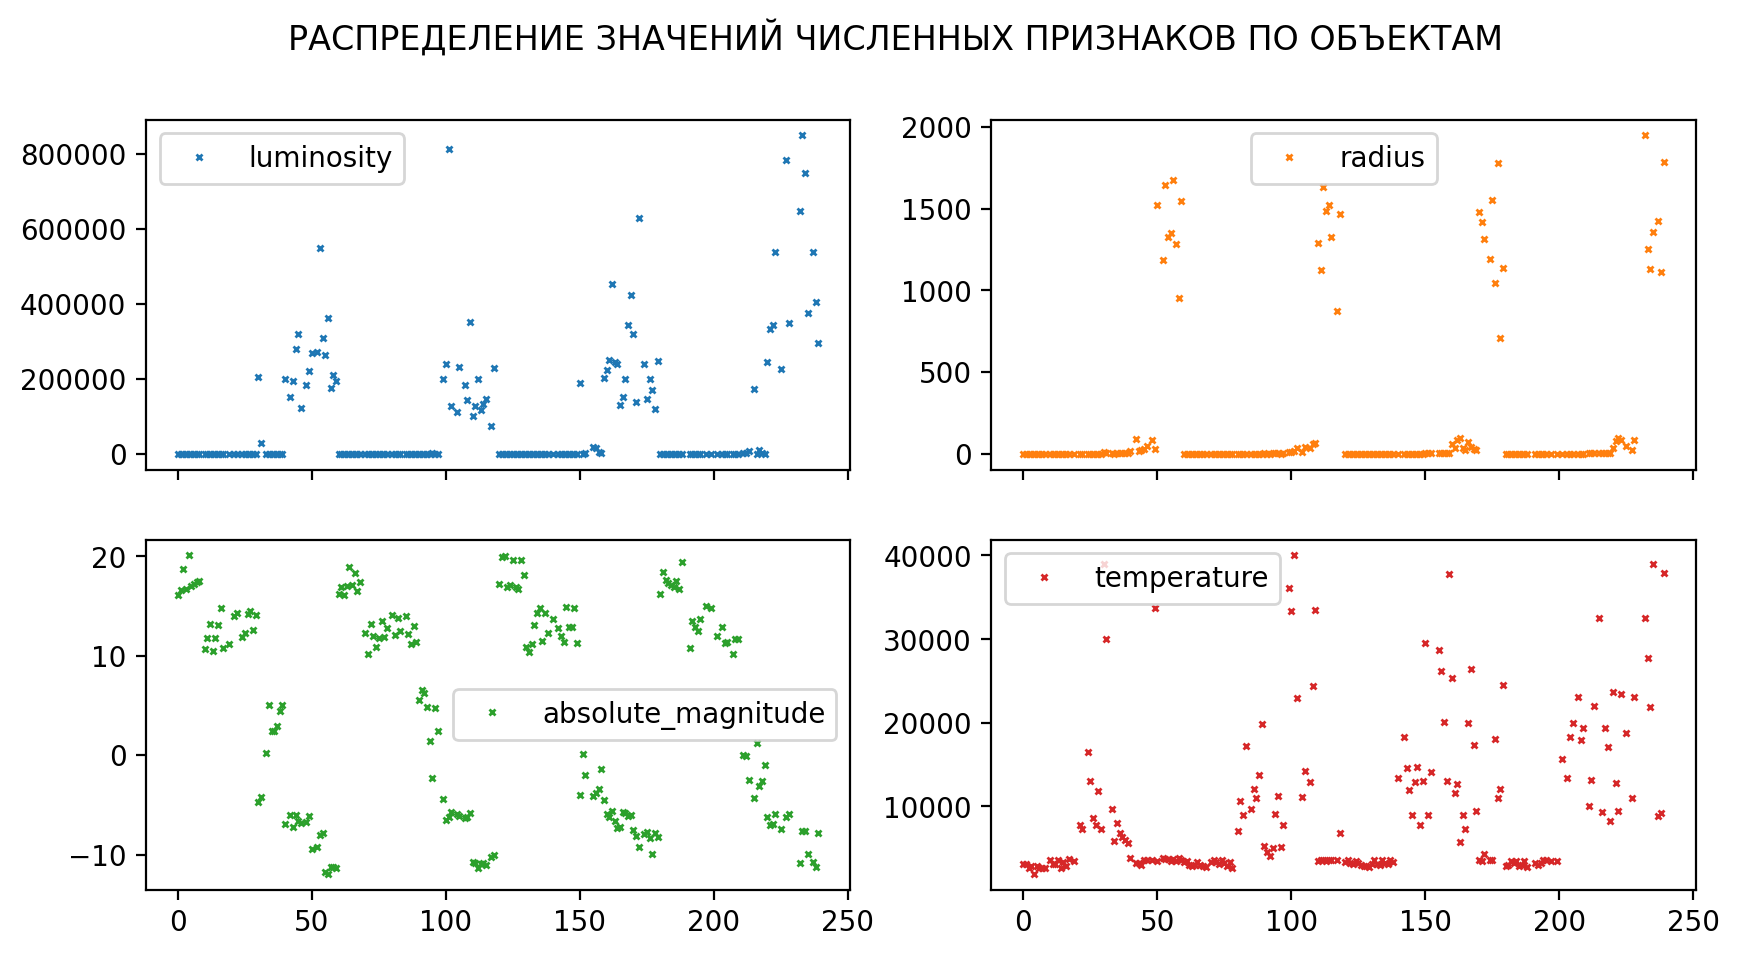

In [33]:
df[numerical_columns+target_column].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 2),
    figsize=(10, 5), markersize=2, 
    title = 'Распределение значений численных признаков по объектам'.upper()
)
plt.legend(loc='upper left')
plt.show()

Мы видим, что датасет собран из 4 порций данных, в каждой из которых наблюдаем убвываение абсолютной зведной величины. 

Значения относительного радиуса группируются в два кластера: около нуля и 1000–2000.


Доля звезд с небольшой отсносительной светимостью и небольшим радиусом в датасете намного больше остальных. Мы наблюдаем дисбаланс данных.

Посмотрим на распределение объектов по категориям.

In [34]:
df.star_type.value_counts()

0    37
1    34
3    34
2    33
4    33
5    33
Name: star_type, dtype: int64

По типам звезд объекты распределены равномерно.

In [35]:
df.star_color.value_counts()

Red                   98
Blue                  42
Blue-white            20
Blue White             8
yellow-white           8
White                  6
white                  3
Blue white             3
Yellowish White        3
Orange                 2
Whitish                2
yellowish              2
White-Yellow           1
Blue                   1
Blue-White             1
Orange-Red             1
Yellowish              1
Pale yellow orange     1
Blue white             1
Name: star_color, dtype: int64

Тут мы видим большое количество дубликтов в названиях категорий. Оъекты распределены неравномерно.

#### Выводы

В данных нет дубликатов и пропусков. 

Значения признаков относительный радиус и относительная светимости имют большой разброс. Мы видим много объектов с маленькими значениями и несколько объектов с очень большими значениями.

В категориальном признаке цвет звезды мы видим неявные дубли в значениях.  

### Содержание данных

#### Анализ значений цвет звезды

Ранее мы видели, что в датасете 18 вариантов цвета звезд. [Современная спетральная классификации звезд](https://ru.wikipedia.org/wiki/Спектральная_классификация_звёзд) (Йеркская классификация или классификация Моргана — Кинана) по цвету имеет 7 классов (цветов)

|#|Класс|Температура (Кельвин, K)|Цвет|Показатель цвета B−V|Абсолютная звёздная величина $M_V$|
|---|---|---|---|---|---|
|1|O|> 30 000|Голубой|−0,3|−5,7…−3,3|
|2|B|10 000—30 000|Бело-голубой|−0,2|−4,1…+1,5|
|3|A|7400—10 000|Белый|0| +0,7…+3,1|
|4|F|6000—7400|Жёлто-белый| +0,4|+2,6…+4,6|
|5|G|5000—6000|Жёлтый| +0,6|+4,4…+6,0|
|6|K|3800—5000|Оранжевый| +1,0|+5,9…+9,0|
|7|M|2500—3800|Красный| +1,5|+9,0…+16|

В наших данных 18 униеальных значений цвета звезд. Изучим эти значения.

In [36]:
df.star_color = df.star_color.apply(normalize_color_values)
df.star_color.value_counts()

red                   98
blue                  43
blue white            33
white                  9
yellow white           8
yellowish              3
yellowish white        3
whitish                2
orange                 2
pale yellow orange     1
white yellow           1
orange red             1
Name: star_color, dtype: int64

Поскольку мы не знаем прицип присвоения значений цвета в нашем датасете, сверим распределение температур и звездных величин с классификацией.

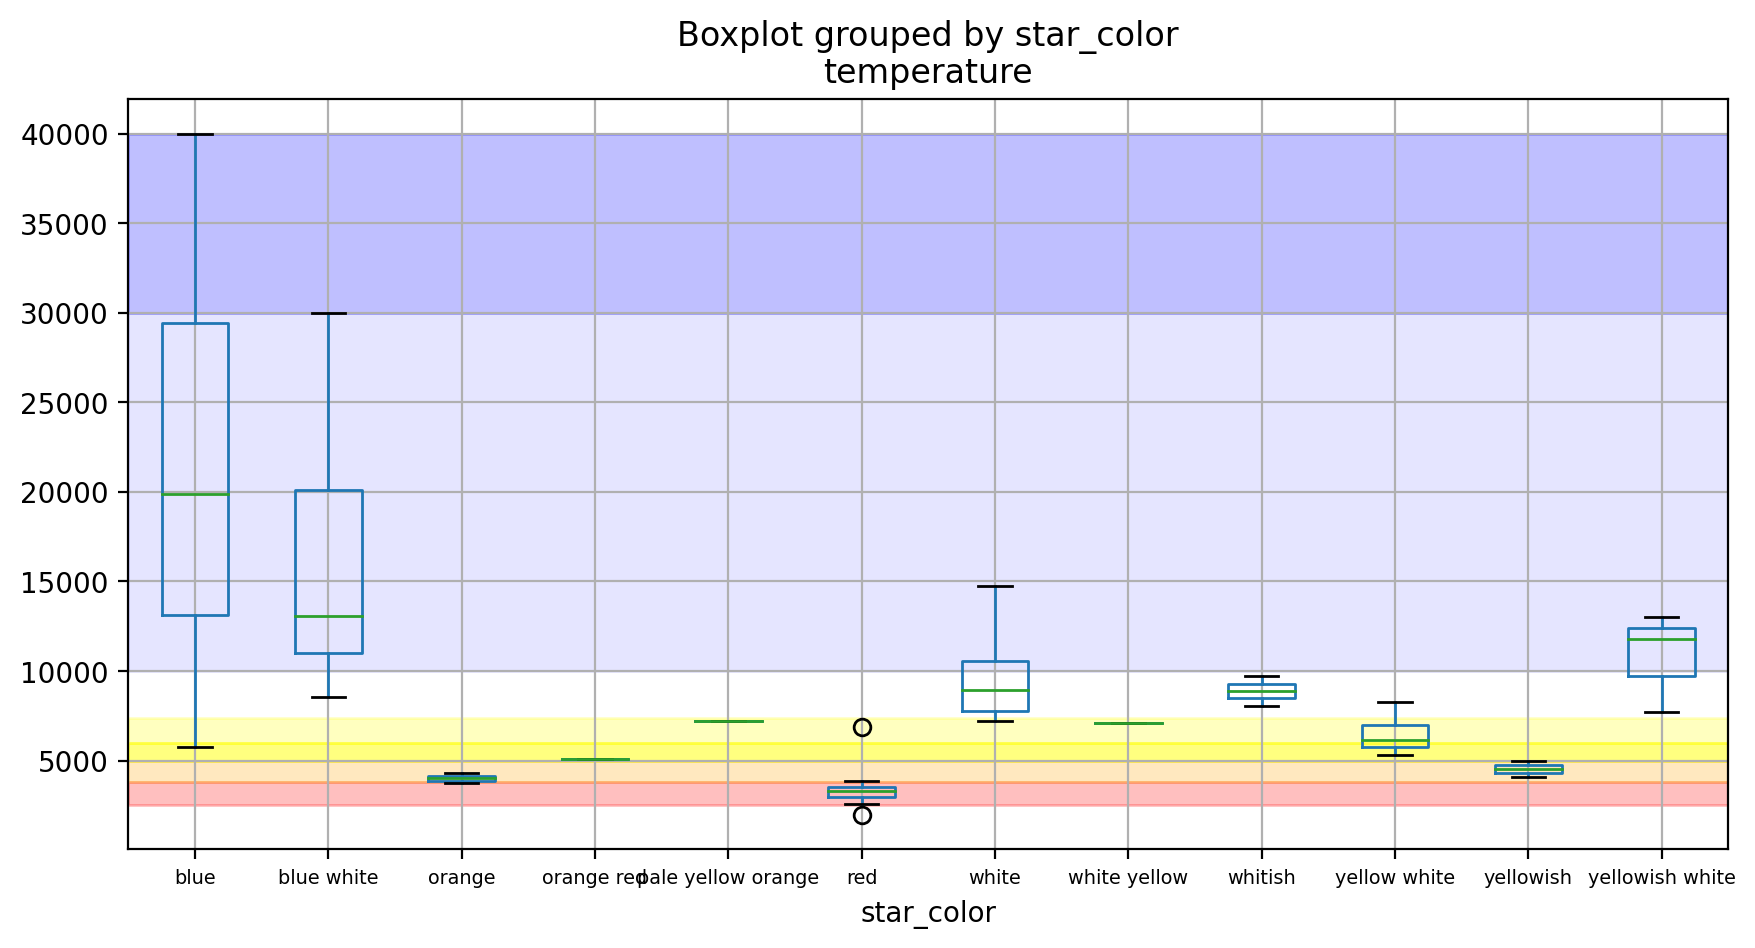

In [37]:
df.boxplot(column=["temperature"], by="star_color", figsize=(10,5))
plt.xticks(fontsize="x-small", rotation=0)
plt.axhspan(2500, 3800, color="red", alpha=.25)
plt.axhspan(3800, 5000, color="orange", alpha=.25)
plt.axhspan(5000, 6000, color="yellow", alpha=.5)
plt.axhspan(6000, 7400, color="yellow", alpha=.25)
plt.axhspan(7400, 10000, color="white", alpha=.1)
plt.axhspan(10000, 30000, color="blue", alpha=.1)
plt.axhspan(30000, 40000, color="blue", alpha=.25)
plt.show()

Мы видим, что некоторые цвета в нашем датасете не соответствуют Йеркской классификации: температура голубых звезд и "yellowish white" в нашем датасете попадает в диапозн темперетар бело-голубых звезд. 

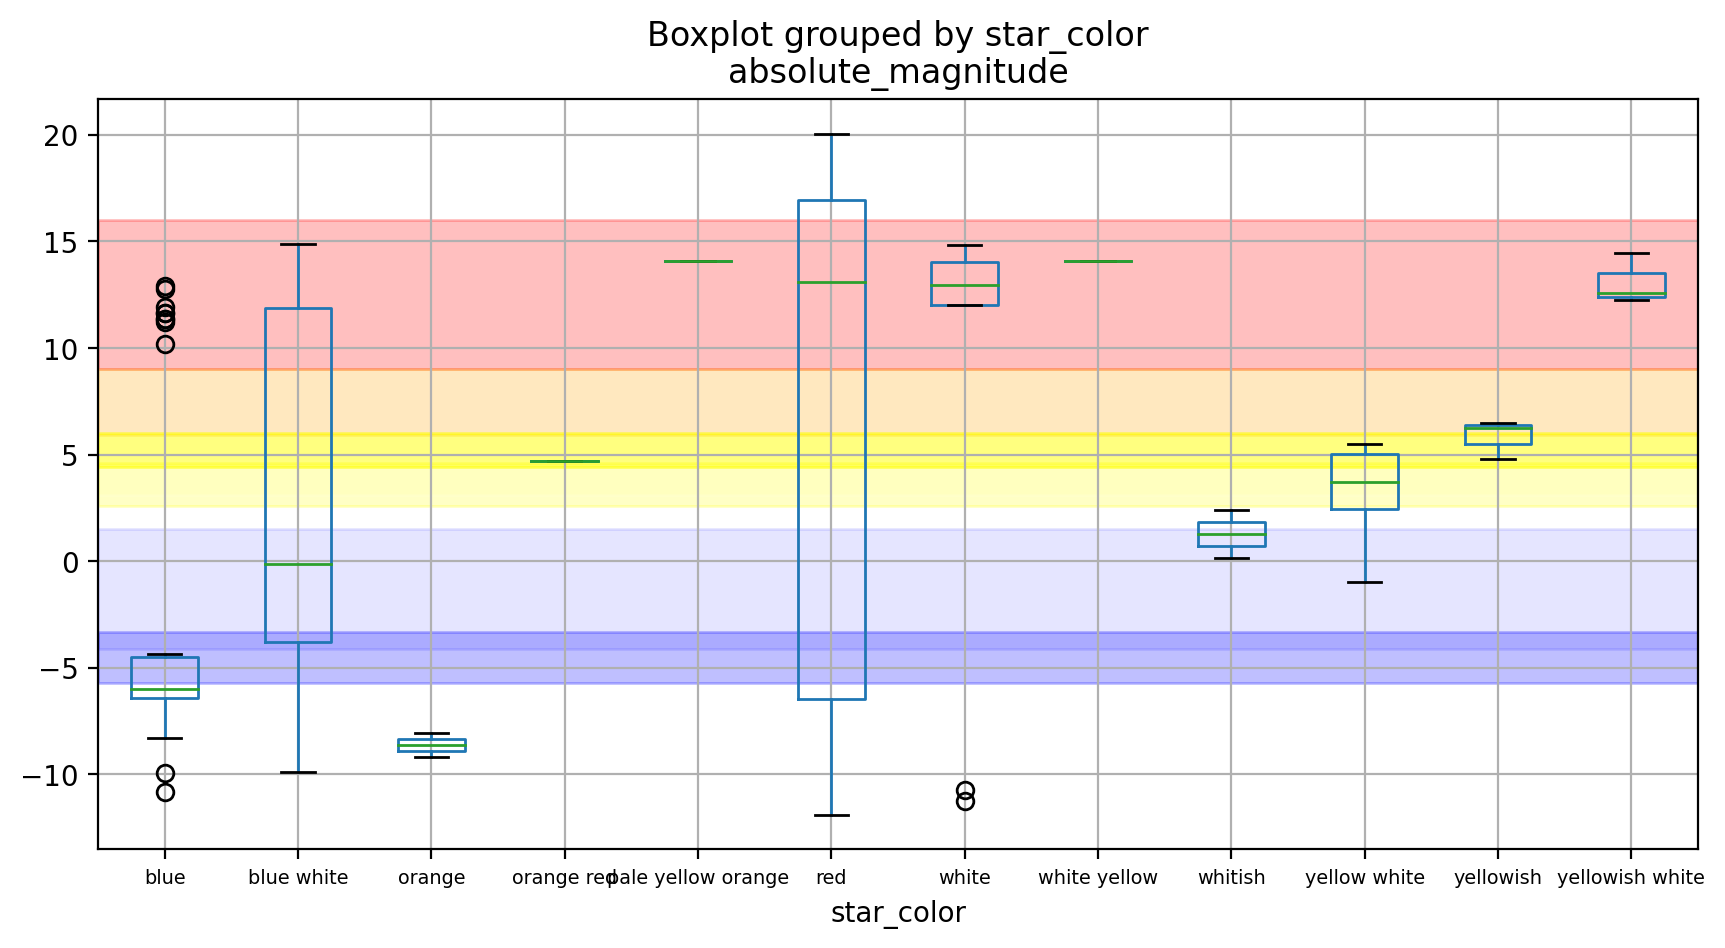

In [38]:
df.boxplot(column=["absolute_magnitude"], by="star_color", figsize=(10,5))
plt.xticks(fontsize="x-small", rotation=0)
plt.axhspan(9, 16, color="red", alpha=.25)
plt.axhspan(5.9, 9, color="orange", alpha=.25)
plt.axhspan(4.4, 6, color="yellow", alpha=.5)
plt.axhspan(2.6, 4.6, color="yellow", alpha=.25)
plt.axhspan(.7, 3.1, color="white", alpha=.1)
plt.axhspan(-4.1, 1.5, color="blue", alpha=.1)
plt.axhspan(-5.7, -3.3, color="blue", alpha=.25)
plt.show()

Тут мы видим, что по абсолютной зведной величине цвета в нашем датасете в большинстве случаев не совпадают с Йерской классификацией.

Значит мы не можем утвежрждать, что цвета отражают современную спекральную классификацию и не можем ориентироваться на нее. 

Сопоставим редкие значения цветов с часто встречающмися, опираясь на сходство по температуре.

In [39]:
reduce_color_values_dict = {
    "yellowish": "orange",
    "yellowish white": "yellow white",
    "pale yellow orange": "yellow white",
    "whitish": "white",
    "white yellow": "yellow white"
}
color_value_reduction_func = partial(reduce_color_values, reduce_color_values_dict)

Оценим количество объектов по значениям цвета после унификации значений.

In [40]:
df.star_color = df.star_color.apply(color_value_reduction_func)
df.star_color.value_counts()

red             98
blue            43
blue white      33
yellow white    13
white           11
orange           5
orange red       1
Name: star_color, dtype: int64

Мы сократили количество цветов до 6 значений. Объекты по-прежнему распределены неравномероно: количество белых и оранжевых звезд на порядок меньше количества красных и голубых.

#### Целевой признак

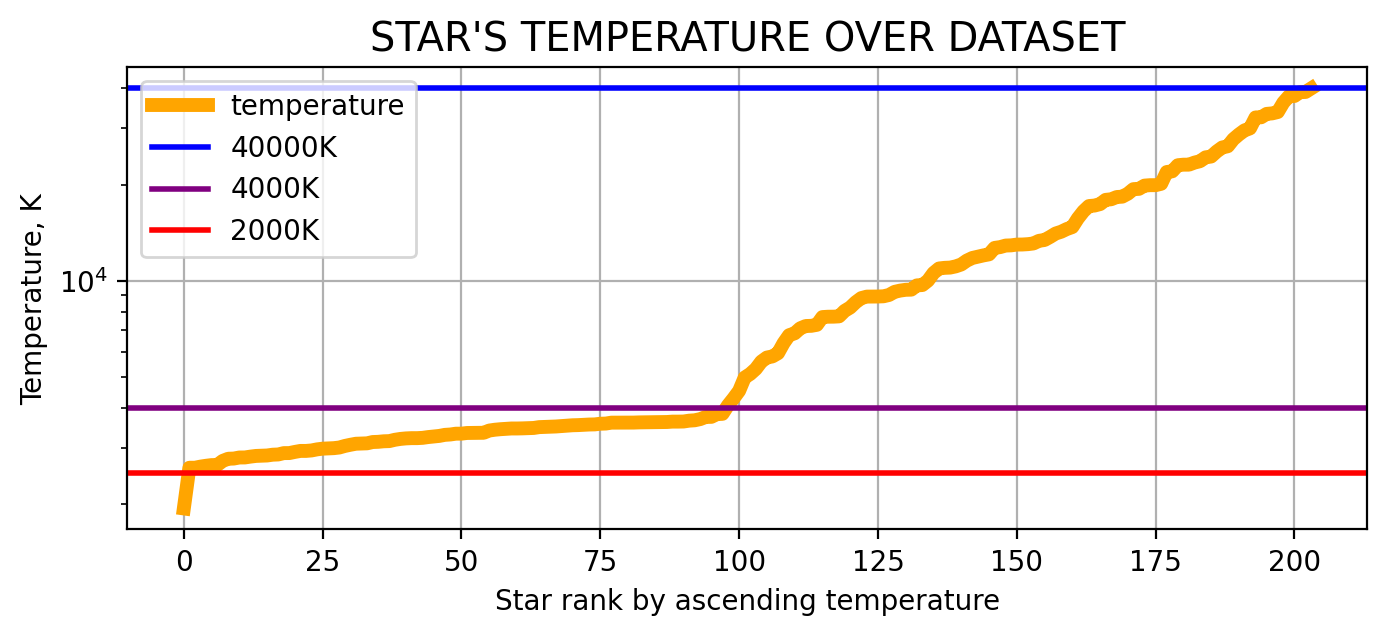

In [41]:
plt.figure(figsize=(8,3))

temperatures = df.temperature.sort_values().reset_index(drop=True)
temperatures.plot(logy=True, grid=True, lw=5,  color="orange", label="temperature")
plt.axhline(40000, color="blue", lw=2, label="40000K")
plt.axhline(4000, color="purple", lw=2, label="4000K")
plt.axhline(2500, color="red", lw=2, label="2000K")
plt.ylabel("Temperature, K")
plt.xlabel("Star rank by ascending temperature")
plt.title("Star's temperature over dataset".upper(), fontsize="x-large")
plt.legend(loc="upper left")
plt.show()

#### Распределение значений

Оценим распределение значений для числовых признаков.

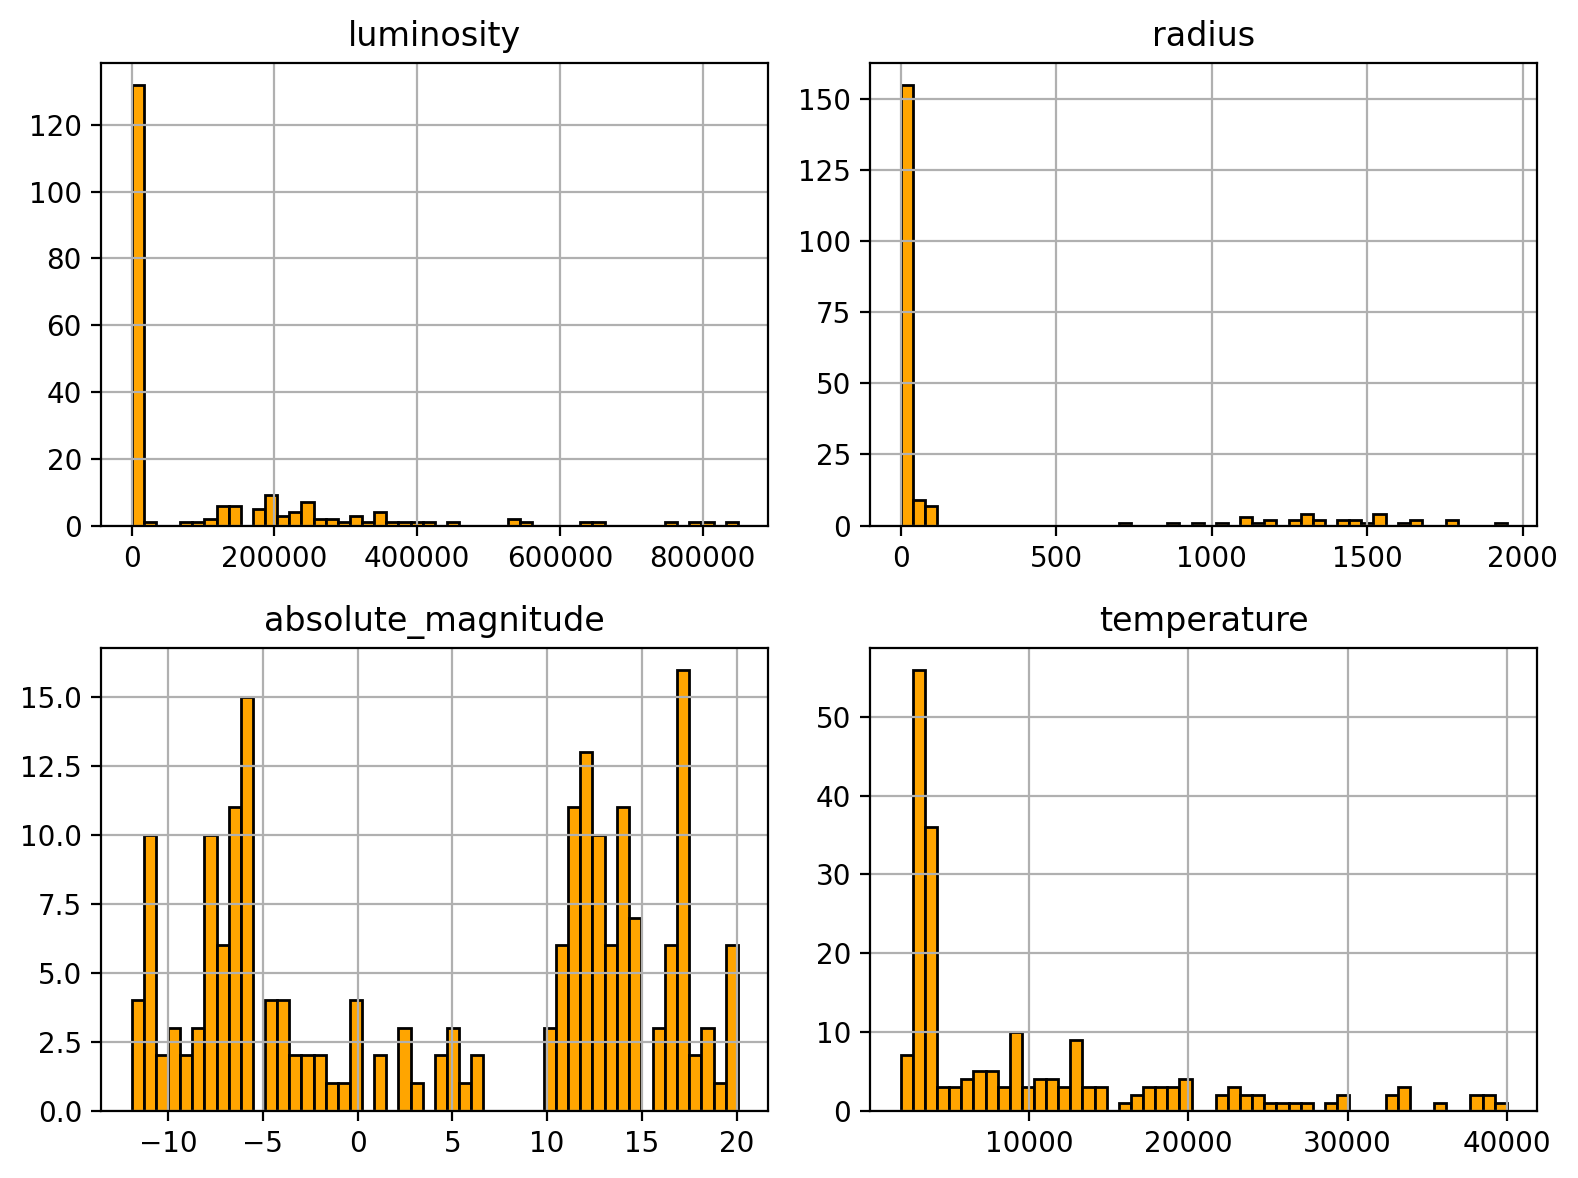

In [42]:
df[numerical_columns + target_column].hist(bins=50,
                                           figsize=(8, 6),
                                           layout=(-1, 2),
                                           color="orange",
                                           edgecolor="black")
plt.tight_layout()
plt.show()

Мы видим, что наш датасет состоит из подмножеств объектов с разными распределениями. Так, у относительных светимости и радиуса мы видим похожее на логнормальное распределение значений в районе нуля, и несколько групп значений с похожим на нормальное распределение: для светимости в раойне 200, 350 и 800 тыс, для радиуса в раоне 1300. 

Мы знаем, что звезды объединяют в классы по схожести признаков, и в наших данных несколько таких классов. Поэтому наблюдаемые распределения соответветсвтуют ожиданиям. 

#### Взаимосвязь признаков

Рассмотрим, как связаны между собой числовые признаки и числовые и категориальные.

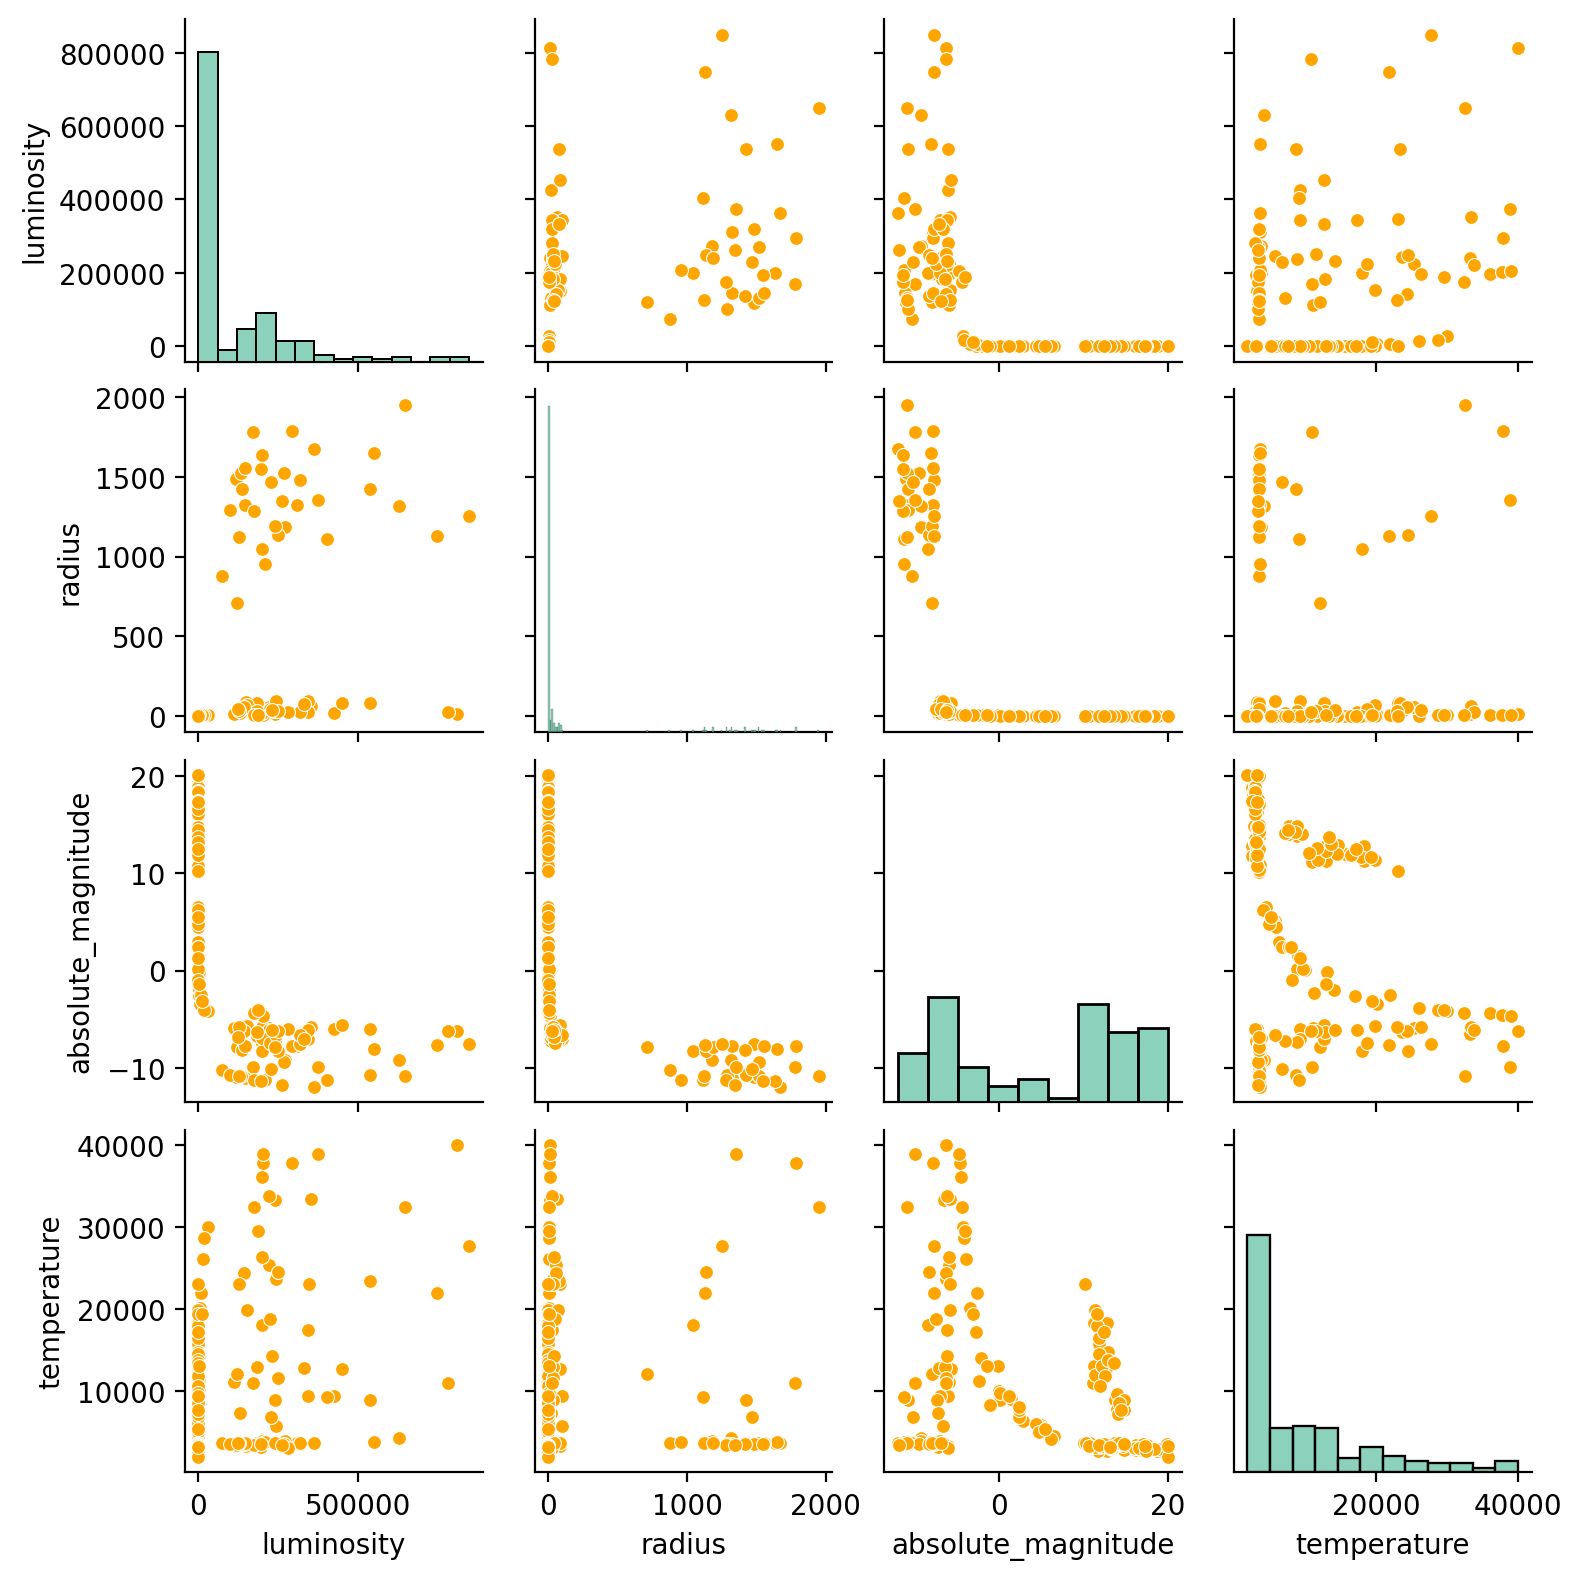

In [43]:
with sns.color_palette("Set2"):
    sns.pairplot(df[numerical_columns + target_column],
                 height=2,
                 plot_kws={
                     "s": 25,
                     "color": "orange"
                 })
plt.show()

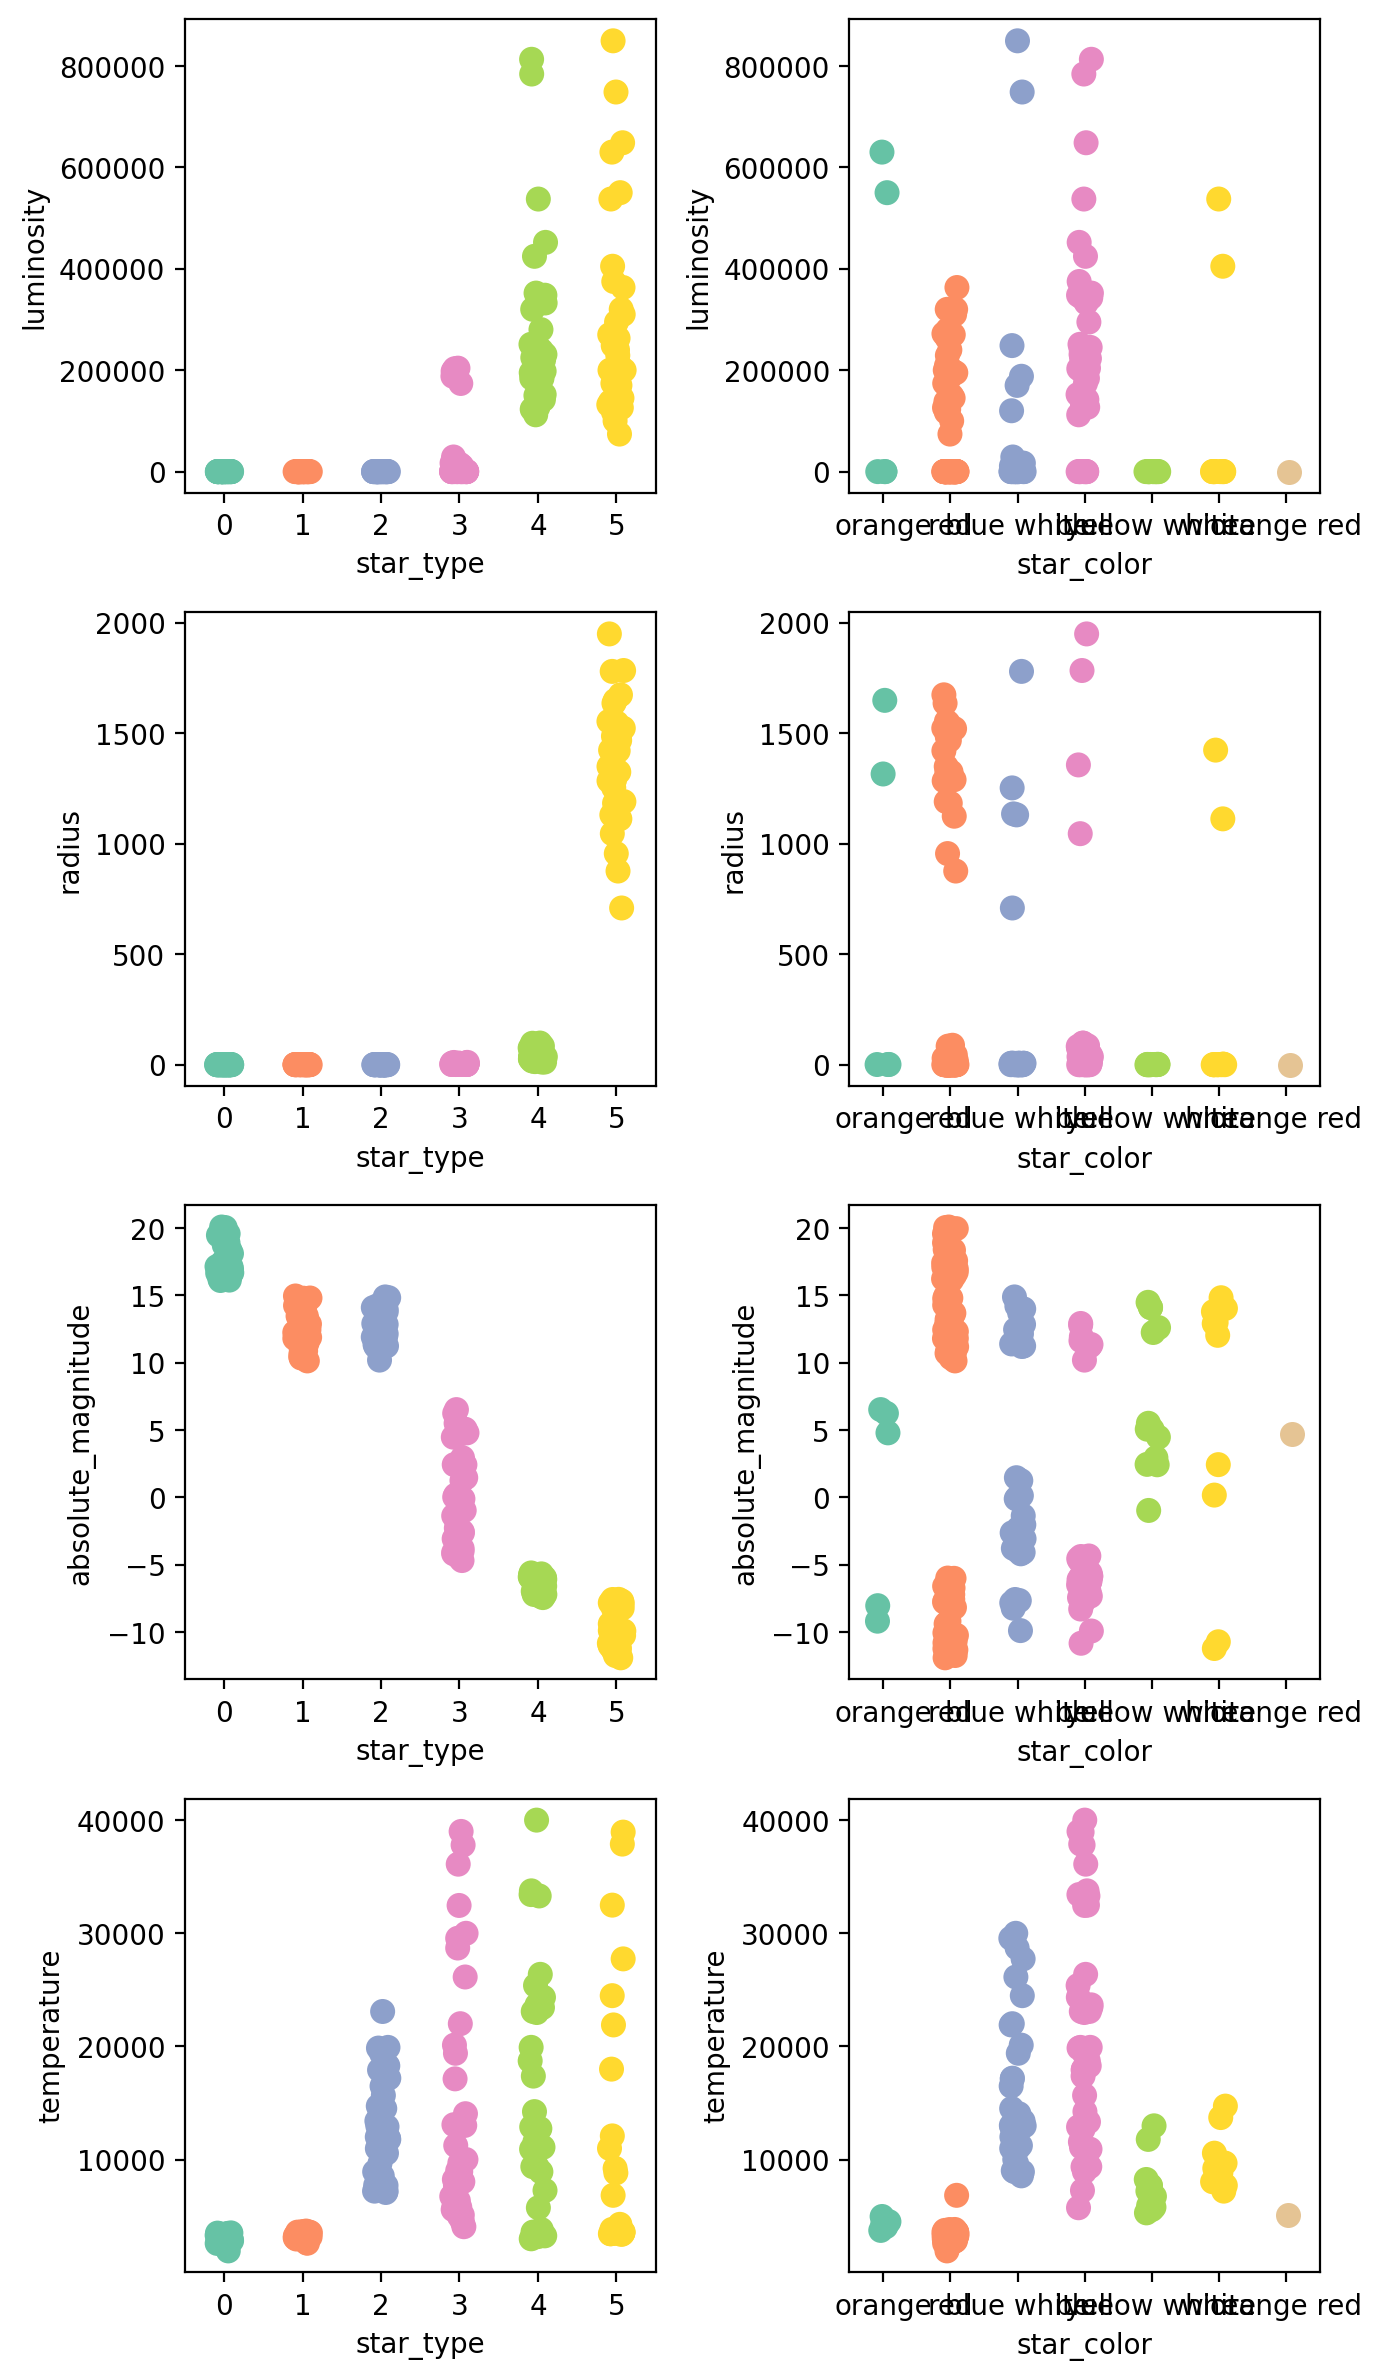

In [44]:
with sns.color_palette("Set2"):
    fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(7, 12))
    for j, category in enumerate(categorical_columns):
        for i, col in enumerate(numerical_columns+target_column):
            sns.stripplot(data=df,
                          x=category,
                          y=col,
                          ax=axes[i, j],
                          size=9)
plt.tight_layout()
plt.show()

Мы видим, что связи между признаками есть, но они в большинстве случаев носят нелинейный характер. Линейную связь вилим только между типом звезды и абсолютной звездной величиной. Еще видим степенную зависимость между абсолютной звездной величиной и температурой в середине диапазона значений $M_v$.

#### Анализ мультиколлинеарности

- https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
- https://etav.github.io/python/vif_factor_python.html
- https://towardsdatascience.com/how-to-remove-multicollinearity-in-dataset-using-pca-4b4561c28d0b

Поскольку мы видим связи между признаками, выполним анализ мультиколлинеарности признаков.

Закодируем категориальные признаки и подготовим датасет для анализа.

In [45]:
ohe_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
encoded = pd.DataFrame(ohe_encoder.fit_transform(
    df[categorical_columns]),
                       index=df.index)

encoded.columns = ohe_encoder.get_feature_names(categorical_columns)

encoded = (
    df
    # удалим целевой признак и категориальные признаки
    .drop(columns=target_column + categorical_columns)
    # присоединим закодированные признаки
    .join(encoded)
    # удалим первую закодированную категорию каждого признака
    .drop(columns=[encoded.columns[0], encoded.columns[len(ohe_encoder.categories_[0])]
    ]))

Рассчитаем фактор инфляции дисперсии $\mathit{VIF} = \frac{1}{1 - R^2}$ для признаков датасета. Значения больше 5 говорят о высокой мультиколлинеарности рассматриваемого признака с остальными признаками датасета.

In [46]:
encoded.head().T

,91,3,95,10,195
luminosity,0.153,0.0002,672.00,0.0029,0.0027
radius,0.865,0.1600,6.98,0.5100,0.6700
absolute_magnitude,6.506,16.6500,-2.30,10.6900,13.6670
star_type_1,0.000,0.0000,0.00,1.0000,1.0000
star_type_2,0.000,0.0000,0.00,0.0000,0.0000
star_type_3,1.000,0.0000,1.00,0.0000,0.0000
star_type_4,0.000,0.0000,0.00,0.0000,0.0000
star_type_5,0.000,0.0000,0.00,0.0000,0.0000
star_color_blue white,0.000,0.0000,1.00,0.0000,0.0000
star_color_orange,1.000,0.0000,0.00,0.0000,0.0000


Расчитаем фактора инфляции дисперсии.

Перед анализом выполним преобразования данных: переведем `luminosity` и `radius` в логарифмическую шкалу, чтобы сократить разборос значений, а также выполним масштабирование всех числовых признаков.

In [47]:
encoded[["luminosity", "radius"]] = np.log10(encoded[["luminosity", "radius"]])
scaler = MinMaxScaler()
encoded[numerical_columns] = scaler.fit_transform(encoded[numerical_columns])

In [48]:
vif = calc_vif(exogs=encoded.columns, data=encoded)
vif[vif.VIF>5].VIF

luminosity             65.804153
radius                111.452125
absolute_magnitude     82.172351
star_type_2            13.698488
star_type_3            30.221785
star_type_4            46.740669
star_type_5            87.278255
Name: VIF, dtype: float64

У семи признаков значение фактора инфляции дисперсии больше 10. Такой результат — следствие их мультиколлинеарности относительно остальных признаков нашего набора.

Изучим зависимость доли дисперсии, объясняемой признаками, при изменении размерности данных. Так мы сможем сократить количество признаков и избежать влияния мультиколиеарности.

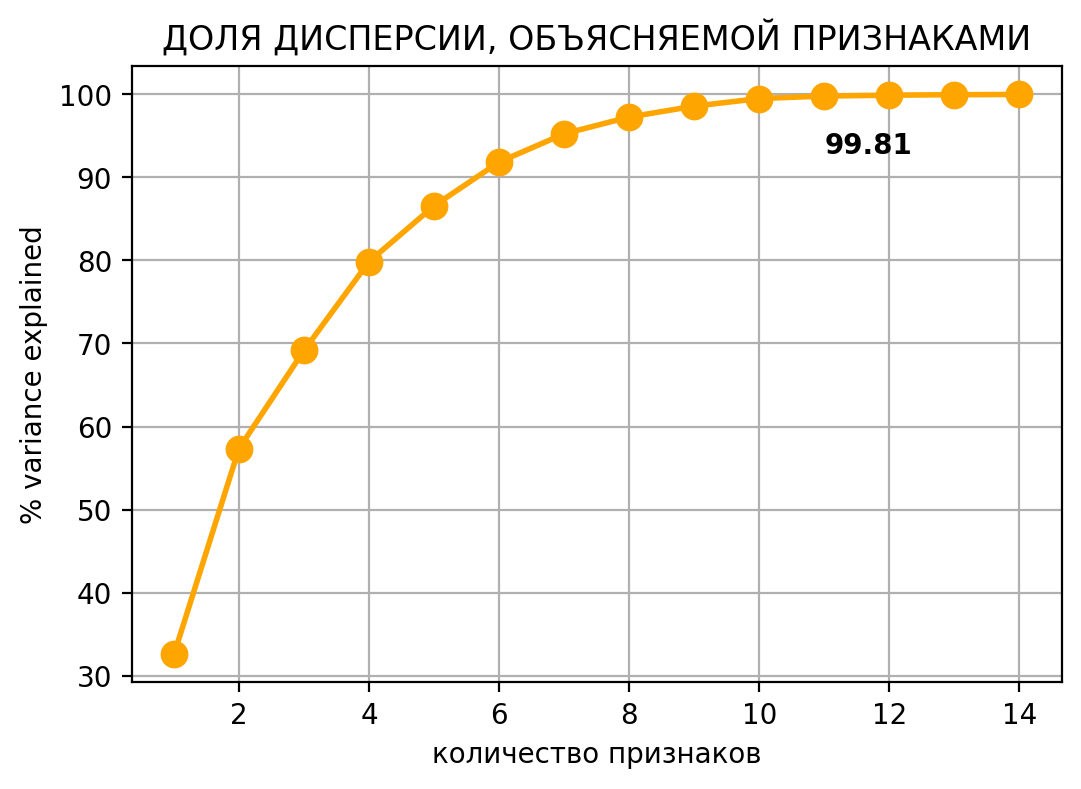

In [49]:
pca = PCA(n_components=encoded.shape[1])
pca_data = pca.fit_transform(encoded)

percent_var_explained = pca.explained_variance_ / (np.sum(
    pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.figure(figsize=(6, 4))
plt.plot(range(1, encoded.shape[1] + 1),
         cumm_var_explained * 100,
         markersize=9,
         marker="o",
         lw=2,
         color="orange")
plt.text(11, cumm_var_explained[10]*100 - 7, f"{cumm_var_explained[10]*100:.2f}", fontweight="bold")
plt.grid()
plt.title("Доля дисперсии, объясняемой признаками".upper())
plt.xlabel("количество признаков")
plt.ylabel("% variance explained")
plt.show()

Мы видим, что 99.91% дисперсии объясняется первыми 11-ю главными компонентами. Тогда при подготовке данных уменьшим разменость до 11.

### Выводы

Сруктура и содержание данных соответствуют описанию в задаче, пропусков и дубликатов в данных нет.

В данных три численных непрерывных признака и два категориальных.

Значения численных признаков имеют большой диапазон, возможно надо перевести эти признаки в логарифмическую шкалу. 

Значения цвета в датасете представлены 18 значениями, среди которых есть скрытые дубли из-за разного регистра и использования либо дефиса, либо пробела. Также используются разные варианты описания цвета. Мы разработали функции сокращения количества значений за счет удаления неявных дубликатов `normalize_color_values` и объединили редкие значения в более крупные группы, ориентируясь на значения температуры для цветов. Функция для сокращения значений, использующая словарь соответствий, —`color_value_reduction_func`.

Анализируя взаимосвязи признаков, мы выявили шесть признаков со значением фактора инфляции дисперсии больше 5. Анализ главных компонент показывает, что 98.79% дисперсии объясняется 9-ю главными компонентами.

## Подготовка данных

### Сокращение количества значений признака цвет звезды

In [50]:
X_train.star_color = X_train.star_color.apply(normalize_color_values)
X_train.star_color = X_train.star_color.apply(color_value_reduction_func)

/Volumes/T7/working/yp14-torch-nn-refression/venv/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [51]:
X_test.star_color = X_test.star_color.apply(normalize_color_values)
X_test.star_color = X_test.star_color.apply(color_value_reduction_func)

In [52]:
X_train.star_color.nunique()

7

Значения унифицированы.

### Кодирование категориальных признаков

In [53]:
ohe_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
ohe_encoder.fit(X_train[categorical_columns])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [54]:
encoded_columns = ohe_encoder.get_feature_names(categorical_columns)

X_train = (
    X_train
    .drop(columns=categorical_columns)
    .join(pd.DataFrame(ohe_encoder.transform(X_train[categorical_columns]),
                       index=X_train.index, 
                       columns=encoded_columns))
    .drop(columns=[encoded_columns[0], encoded_columns[len(ohe_encoder.categories_[0])]
    ]))

X_test = (
    X_test
    .drop(columns=categorical_columns)
    .join(pd.DataFrame(ohe_encoder.transform(X_test[categorical_columns]),
                       index=X_test.index, 
                       columns=encoded_columns))
    .drop(columns=[encoded_columns[0], encoded_columns[len(ohe_encoder.categories_[0])]
    ]))

X_train.shape, X_test.shape

((204, 14), (36, 14))

In [55]:
X_train.head().T

,91,3,95,10,195
luminosity,0.153,0.0002,672.00,0.0029,0.0027
radius,0.865,0.1600,6.98,0.5100,0.6700
absolute_magnitude,6.506,16.6500,-2.30,10.6900,13.6670
star_type_1,0.000,0.0000,0.00,1.0000,1.0000
star_type_2,0.000,0.0000,0.00,0.0000,0.0000
star_type_3,1.000,0.0000,1.00,0.0000,0.0000
star_type_4,0.000,0.0000,0.00,0.0000,0.0000
star_type_5,0.000,0.0000,0.00,0.0000,0.0000
star_color_blue white,0.000,0.0000,1.00,0.0000,0.0000
star_color_orange,1.000,0.0000,0.00,0.0000,0.0000


Признаки закодированы.

### Масштабирование числовых признаков

Переведем значения относительной светимости и радиуса в логарифмическую шкалу.

In [56]:
X_train[["luminosity", "radius"]] = np.log10(X_train[["luminosity", "radius"]])
X_test[["luminosity", "radius"]] = np.log10(X_test[["luminosity", "radius"]])

In [57]:
scaler = MinMaxScaler()
scaler.fit(X_train[numerical_columns])

MinMaxScaler()

In [58]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
X_train[numerical_columns].describe()

,luminosity,radius,absolute_magnitude
count,204.000000,204.000000,204.000000
mean,0.464503,0.434886,0.520727
std,0.393801,0.315940,0.329355
min,0.000000,0.000000,0.000000
25%,0.097230,0.197827,0.180550
50%,0.242292,0.352917,0.693558
75%,0.933742,0.676011,0.810194
max,1.000000,1.000000,1.000000


Масштабирование сделано.

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 91 to 118
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   luminosity               204 non-null    float64
 1   radius                   204 non-null    float64
 2   absolute_magnitude       204 non-null    float64
 3   star_type_1              204 non-null    float64
 4   star_type_2              204 non-null    float64
 5   star_type_3              204 non-null    float64
 6   star_type_4              204 non-null    float64
 7   star_type_5              204 non-null    float64
 8   star_color_blue white    204 non-null    float64
 9   star_color_orange        204 non-null    float64
 10  star_color_orange red    204 non-null    float64
 11  star_color_red           204 non-null    float64
 12  star_color_white         204 non-null    float64
 13  star_color_yellow white  204 non-null    float64
dtypes: float64(14)
memory usa

In [60]:
X_train.head()

,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_orange,star_color_orange red,star_color_red,star_color_white,star_color_yellow white
91,0.327308,0.373351,0.576173,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.039691,0.236366,0.893371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
95,0.690630,0.542848,0.300813,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.155526,0.330466,0.707004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
195,0.152431,0.352615,0.800094,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [61]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 236 to 106
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   luminosity               36 non-null     float64
 1   radius                   36 non-null     float64
 2   absolute_magnitude       36 non-null     float64
 3   star_type_1              36 non-null     float64
 4   star_type_2              36 non-null     float64
 5   star_type_3              36 non-null     float64
 6   star_type_4              36 non-null     float64
 7   star_type_5              36 non-null     float64
 8   star_color_blue white    36 non-null     float64
 9   star_color_orange        36 non-null     float64
 10  star_color_orange red    36 non-null     float64
 11  star_color_red           36 non-null     float64
 12  star_color_white         36 non-null     float64
 13  star_color_yellow white  36 non-null     float64
dtypes: float64(14)
memory usa

In [62]:
X_train.shape, y_train.shape

((204, 14), (204,))

In [63]:
X_test.shape, y_test.shape

((36, 14), (36,))

### Сокращение размерности

In [64]:
pca = PCA(n_components=11, random_state=RANDOM_STATE)

In [65]:
X_train = pca.fit_transform(X_train)

In [66]:
X_test = pca.transform(X_test)

### Вывод

Мы подготовили данные в соответствии с выялвенными на этапе анализа выводами: сократили количество значений признака цвет звезды, закодировали категориальные признаки методом OHE, перевели значения `luminosity` и `radius` в логарифмическую шаклу и выполнили масштабирование численных признаков, приведя среднее значение к нулю и стандартное отклонение к 1.

## Построение baseline модели

Выделим валидационную выборку

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train.values, 
    test_size=0.2, 
    shuffle=True,
    random_state=RANDOM_STATE)

In [68]:
X_train.shape, y_train.shape

((163, 11), (163,))

In [69]:
X_test.shape, y_test.shape

((36, 11), (36,))

In [70]:
X_train_t = torch.FloatTensor(X_train)
X_valid_t = torch.FloatTensor(X_valid)
y_train_t = torch.FloatTensor(y_train)
y_valid_t = torch.FloatTensor(y_valid)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test.values)

In [71]:
X_train_t.size(), X_valid_t.size(), X_test_t.size()

(torch.Size([163, 11]), torch.Size([41, 11]), torch.Size([36, 11]))

### Dummy модель

Оценим значение RMSE для модели, предсказывающей среднюю температуру.

In [72]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
pred = dummy_regr.predict(X_valid)
print(f"""
Dummy MSE\t{mean_squared_error(pred, y_valid):,.0f} 
      RMSE\t{np.sqrt(mean_squared_error(pred, y_valid)):,.0f}
""")


Dummy MSE	66,980,605 
      RMSE	8,184



### Baseline Модель

В качестве базовой построим модель с одним скрытым слоем без регуляризации (класс StarNet). 

Количество входов сети равно количеству признаков. Количество входов скрытого слоя возьмем равным количеству входов сети, а количество выходов в два раза меньше. 

Выход у сети один для задачи регресии

In [73]:
n_in_neurons = X_train_t.size()[1]
n_out_neurons = 1 

In [74]:
params = {
    "learning_rate": 0.01,
    "n_epochs": 5000,
    "batch_size": 200,
    "initialization": "none"
}

In [75]:
base_model = run_experiment(
    StarNet(n_in_neurons=n_in_neurons,
            hidden_neurons=[n_in_neurons, n_in_neurons // 2],
            n_out_neurons=1,
            params=params))

https://app.neptune.ai/dimds/yp14-nn-regression/e/YPNNREG-183


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch     0 Loss train 187,087,440	valid 166,018,544


/Volumes/T7/working/yp14-torch-nn-refression/venv/lib/python3.9/site-packages/neptune/new/handler.py:164: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  self._container.define(self._path, value, wait)


Epoch   500 Loss train 34,354,904	valid 13,902,681
Epoch  1000 Loss train 27,074,092	valid 11,421,920
Epoch  1500 Loss train 23,588,246	valid 11,154,889
Epoch  2000 Loss train 21,491,182	valid 11,086,968
Epoch  2500 Loss train 20,618,416	valid 10,921,252
Epoch  3000 Loss train 19,515,598	valid 10,194,942
Epoch  3500 Loss train 18,418,934	valid 9,549,870
Epoch  4000 Loss train 17,802,228	valid 9,271,980
Epoch  4500 Loss train 17,425,482	valid 9,297,545
Epoch  4999 Loss train 17,136,324	valid 9,343,599
Valid RMSE: 3,057
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 880 operations to synchronize with Neptune. Do not kill this process.
All 880 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/dimds/yp14-nn-regression/e/YPNNREG-183


Построим график План-Факт на тестовой выборке.

In [76]:
preds = base_model.predict(X_test_t).flatten().detach().numpy()

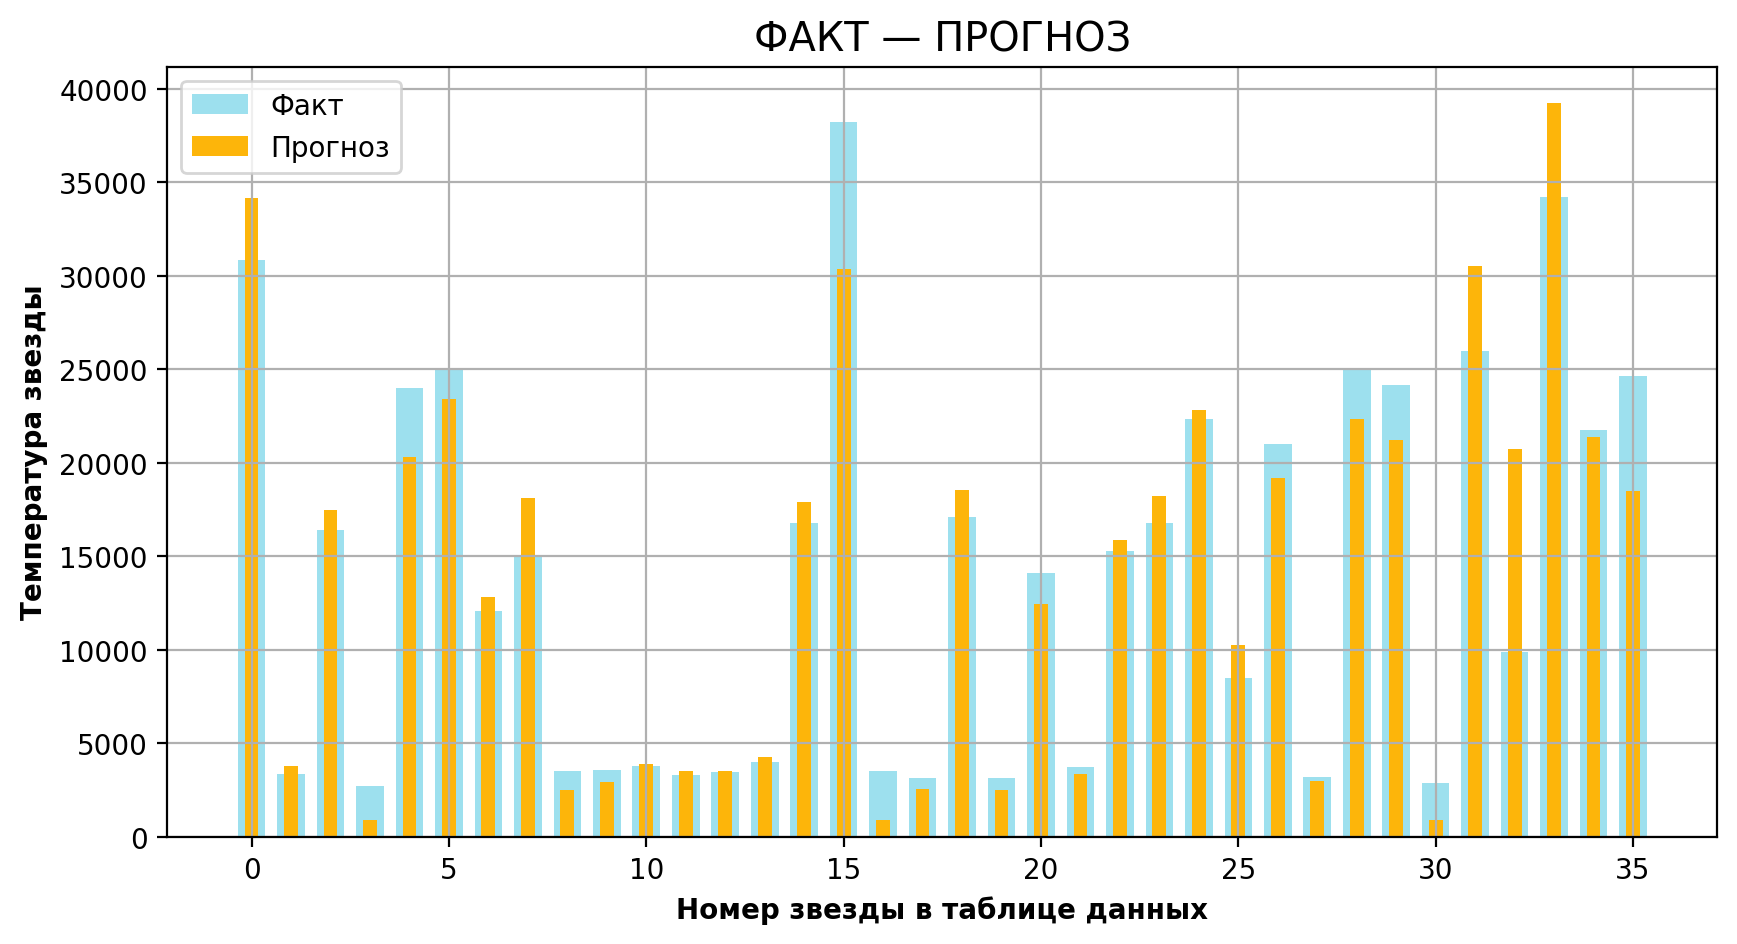

In [77]:
plt.figure(figsize=(10, 5))
x_axis = np.arange(preds.shape[0])
plt.bar(x_axis, y_test_t.flatten(), .7, label="Факт", color="#9DE0EE")
plt.bar(x_axis, preds, 0.35, label="Прогноз", color="#FDB50A")
plt.title("Факт — Прогноз".upper(), fontsize="x-large")
plt.ylabel("Температура звезды", fontweight="bold")
plt.xlabel("Номер звезды в таблице данных", fontweight="bold")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

## Улучшение модели

Добавим к модели регуляризацию методом dropout перед скрытым слоем. Вуроятность дропаута добавим к гиперпараметрм модели. При вероятности, равной 0, архитектура модели будет аналогична базовой.

Оценим влияние на RMSE модели следующих гиперпараметров:
- dropout_proba, 
- batch_size,
- learning_rate


In [108]:
dropout_proba = np.linspace(0,.6,7)
batch_size = [ 21,  42, 84, 168]

In [110]:
search_results = {
    "dropout_proba": [],
    "batch_size": [],
    "rmse_min": [],
    "rmse_last": [],
    "best_epoch": [],
    "model": [],
}

print("  DP   BS\tRMSE min\tRMSE last\tBest Epoch")
for dp in dropout_proba:
    params["dropout_proba"] = dp
    for bs in batch_size:
        params["batch_size"] = bs
        _m = StarNetWDO(n_in_neurons=n_in_neurons,
                        hidden_neurons=[n_in_neurons, n_in_neurons // 2],
                        n_out_neurons=1,
                        params=params,
                        verbose=False)
        _m.fit(X_train_t, y_train_t, X_valid_t, y_valid_t)
        print(f"{dp:.2f}  {bs:3d}\t{round(_m.rmse_min):4,d}\t\t{round(_m.rmse_score):4,d}\t\t{_m.best_epoch:4d}")
        search_results["dropout_proba"].append(dp)
        search_results["batch_size"].append(bs)
        search_results["rmse_min"].append(_m.rmse_min)
        search_results["rmse_last"].append(_m.rmse_score)
        search_results["best_epoch"].append(_m.best_epoch)
        search_results["model"].append(_m)        

  DP   BS	RMSE min	RMSE last	Best Epoch
0.00   21	2,907		3,117		1641
0.00   42	2,909		3,089		2129
0.00   84	2,912		3,030		3191
0.00  168	3,052		3,053		4992
0.10   21	2,972		3,261		2580
0.10   42	2,931		3,097		3440
0.10   84	3,017		3,046		4909
0.10  168	2,951		2,970		4881
0.20   21	2,951		3,193		1905
0.20   42	2,932		3,051		3510
0.20   84	2,953		3,016		4486
0.20  168	3,039		3,045		4982
0.30   21	2,930		3,279		2263
0.30   42	2,967		3,142		2667
0.30   84	2,980		3,034		4954
0.30  168	3,236		3,251		4903
0.40   21	3,005		3,243		3708
0.40   42	2,965		3,197		3331
0.40   84	3,039		3,169		3636
0.40  168	3,218		3,218		4999
0.50   21	3,238		3,383		2155
0.50   42	3,378		5,541		 329
0.50   84	3,209		3,227		4996
0.50  168	3,380		3,380		4999
0.60   21	3,288		3,559		1813
0.60   42	3,237		3,560		2131
0.60   84	3,397		3,485		4675
0.60  168	3,375		3,437		4963


In [111]:
_sr = pd.DataFrame(search_results)

In [112]:
_sr.sort_values(by="rmse_min").head()

,dropout_proba,batch_size,rmse_min,rmse_last,best_epoch,model
0,0.0,21,2907.091797,3116.601074,1641,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
1,0.0,42,2909.327637,3088.756592,2129,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
2,0.0,84,2911.680664,3030.115234,3191,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
12,0.3,21,2929.992676,3278.924561,2263,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
5,0.1,42,2930.633301,3097.141357,3440,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."


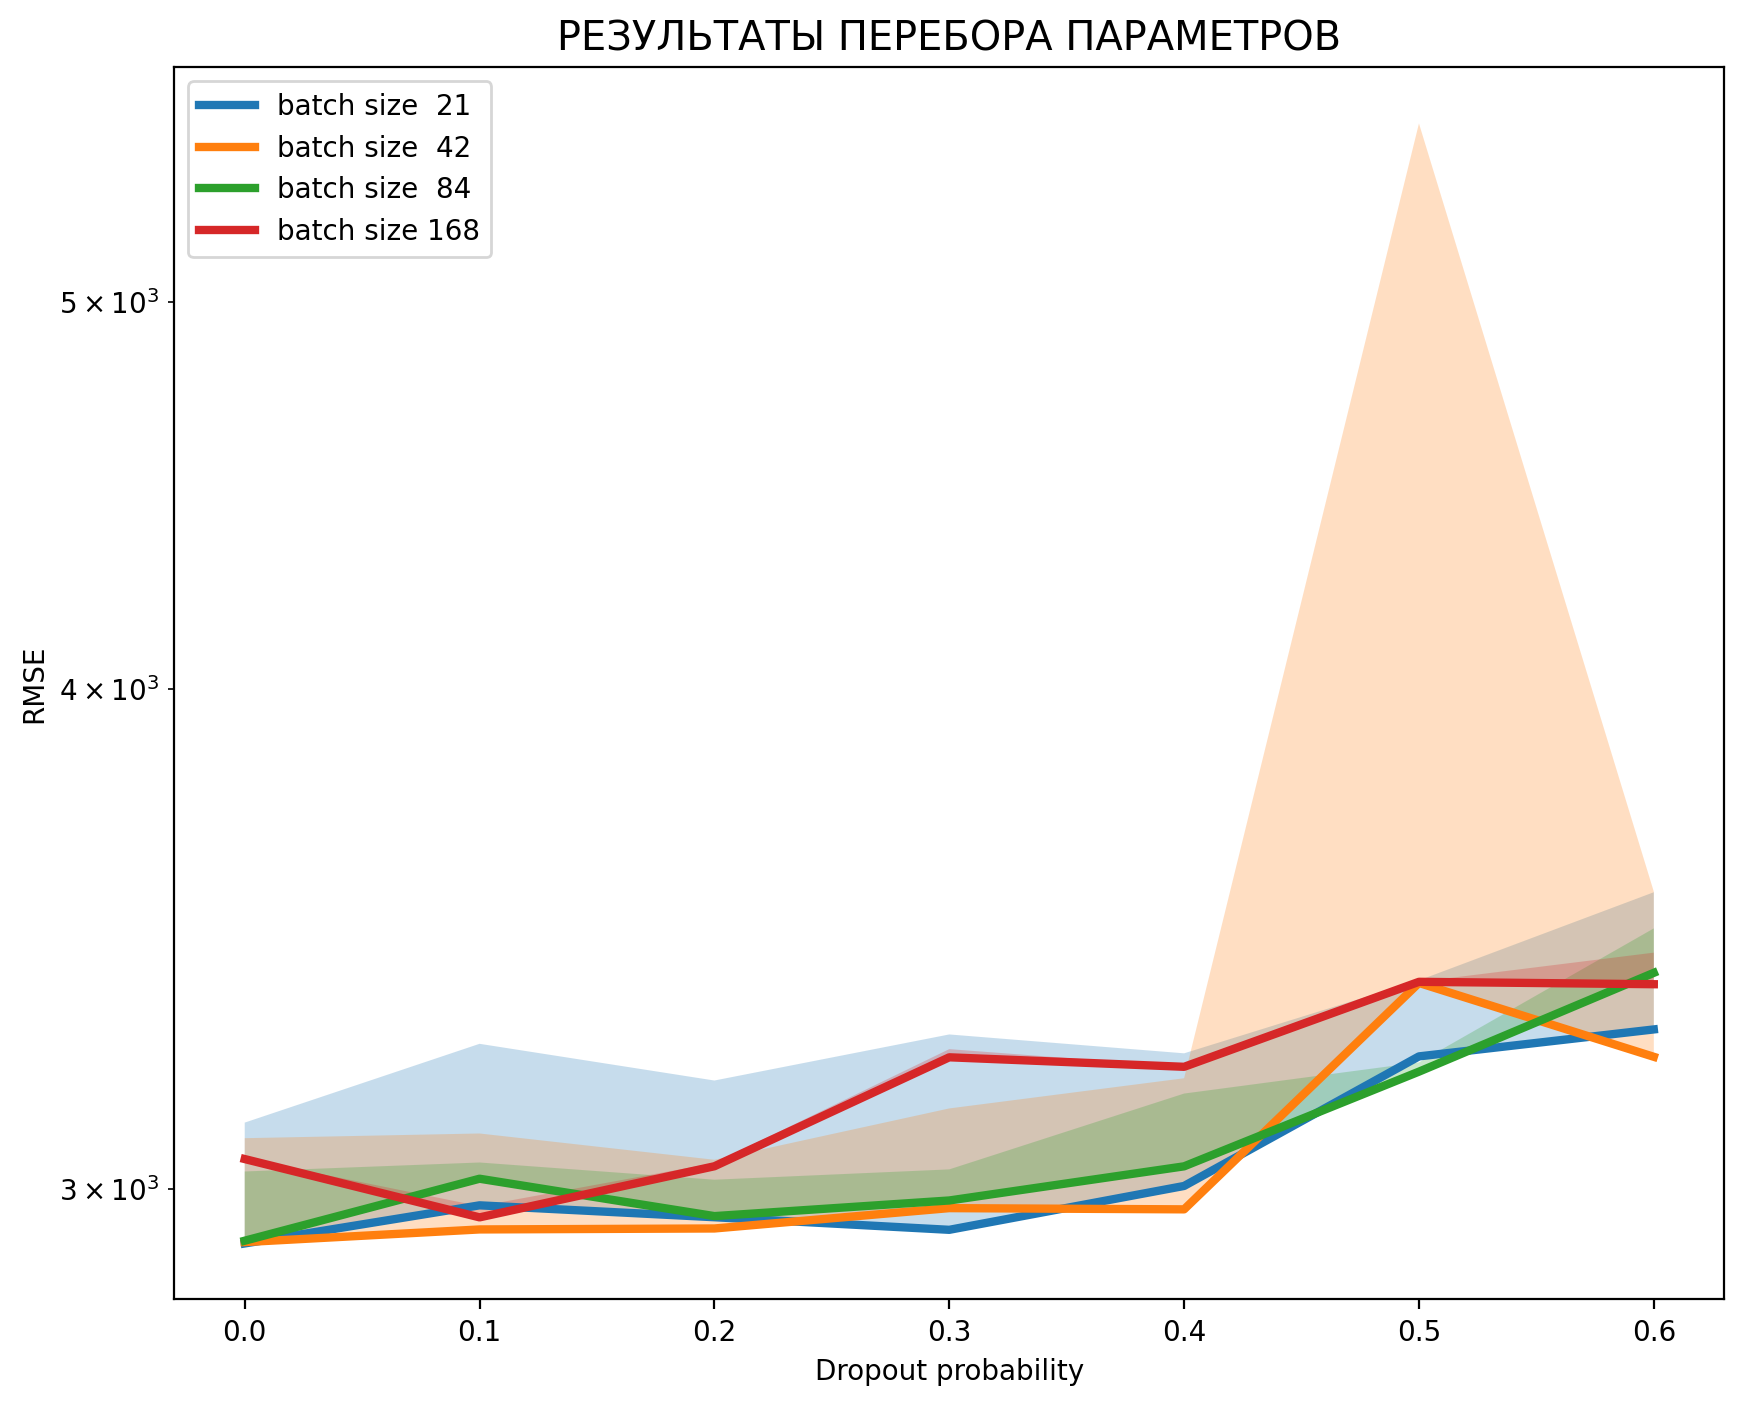

In [113]:
plt.figure(figsize=(10,8))
for bs in batch_size:
    _subset = _sr.query("batch_size == @bs")
    plt.plot(_subset.dropout_proba, _subset.rmse_min, lw=3, label=f"batch size {bs:3d}")
    plt.fill_between(_subset.dropout_proba, _subset.rmse_min, _subset.rmse_last, alpha=.25)
plt.yscale("log")
plt.legend(loc="upper left")
plt.title("Результаты перебора параметров".upper(), fontsize="x-large")
plt.ylabel("RMSE")
plt.xlabel("Dropout probability")
plt.show()

In [83]:
_sr

,dropout_proba,batch_size,rmse_min,rmse_last,best_epoch,model
0,0.000,21,2902.306396,3160.165283,1790,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
1,0.000,42,2944.031494,3081.905518,1986,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
2,0.000,84,2952.004150,3010.259033,3471,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
3,0.000,168,3032.781250,3045.940186,3900,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
4,0.225,21,2987.244873,3287.049072,2377,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
5,0.225,42,2945.857666,3090.333740,2838,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
6,0.225,84,2965.248047,3069.924561,4612,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
7,0.225,168,3218.060791,3238.262451,4821,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
8,0.450,21,3050.234131,3301.872070,2472,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
9,0.450,42,3010.642578,3161.081543,3085,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."


In [79]:
params["learning_rate"] = 0.005
params["n_epochs"] = 7000
params["batch_size"] = 82
m11 = run_experiment(
    StarNet(n_in_neurons=n_in_neurons,
            hidden_neurons=[n_in_neurons, n_in_neurons // 3],
            n_out_neurons=1,
            params=params))

https://app.neptune.ai/dimds/yp14-nn-regression/e/YPNNREG-175
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch     0 Loss train 212,672,512	valid 166,027,632
Epoch   700 Loss train 32,958,774	valid 12,837,194
Epoch  1400 Loss train 24,346,594	valid 12,036,549
Epoch  2100 Loss train 18,448,230	valid 12,708,140
Epoch  2800 Loss train 16,916,410	valid 11,306,854
Epoch  3500 Loss train 24,845,704	valid 10,690,573
Epoch  4200 Loss train 17,346,640	valid 9,987,566
Epoch  4900 Loss train 12,734,845	valid 9,542,373
Epoch  5600 Loss train 20,205,812	valid 9,261,690
Epoch  6300 Loss train 16,712,585	valid 9,054,774
Epoch  6999 Loss train 20,671,100	valid 8,900,009
Valid RMSE: 2,983
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 617 operations to synchronize with Neptune. Do not kill this process

In [80]:
params["initialization"] = "uniform"
params["n_epochs"] = 12000
params["batch_size"] = 200
m2 = run_experiment(
    StarNetWBN(n_in_neurons=n_in_neurons,
               hidden_neurons=[n_in_neurons, n_in_neurons // 3],
               n_out_neurons=1,
               params=params))

Initialized with uniform
https://app.neptune.ai/dimds/yp14-nn-regression/e/YPNNREG-176
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch     0 Loss train 187,082,896	valid 166,124,432
Epoch  1200 Loss train 177,030,912	valid 157,346,032
Epoch  2400 Loss train 153,260,608	valid 142,451,328
Epoch  3600 Loss train 122,961,256	valid 141,152,640
Epoch  4800 Loss train 91,105,064	valid 84,544,840
Epoch  6000 Loss train 61,610,688	valid 58,511,384
Epoch  7200 Loss train 37,625,172	valid 36,935,816
Epoch  8400 Loss train 21,257,006	valid 26,540,388
Epoch  9600 Loss train 13,018,616	valid 21,809,256
Epoch 10800 Loss train 10,788,983	valid 21,485,218
Epoch 11999 Loss train 10,280,790	valid 21,520,046
Valid RMSE: 4,639
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 592 operations to synchronize wi

In [81]:
params["initialization"] = "kaiming_uniform"
params["n_epochs"] = 12000
m3 = run_experiment(
    StarNetWBN(n_in_neurons=n_in_neurons,
               hidden_neurons=[n_in_neurons, n_in_neurons // 3],
               n_out_neurons=1,
               params=params))

Initialized with kaiming_uniform
https://app.neptune.ai/dimds/yp14-nn-regression/e/YPNNREG-177
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch     0 Loss train 187,078,720	valid 166,017,856
Epoch  1200 Loss train 177,597,312	valid 155,844,240
Epoch  2400 Loss train 155,171,872	valid 133,379,968
Epoch  3600 Loss train 126,745,696	valid 105,050,864
Epoch  4800 Loss train 97,094,016	valid 75,514,784
Epoch  6000 Loss train 69,868,800	valid 49,336,328
Epoch  7200 Loss train 47,968,528	valid 29,603,638
Epoch  8400 Loss train 33,181,306	valid 19,077,846
Epoch  9600 Loss train 25,812,408	valid 13,741,836
Epoch 10800 Loss train 23,629,326	valid 13,048,570
Epoch 11999 Loss train 23,186,092	valid 12,008,827
Valid RMSE: 3,465
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 510 operations to synchr

In [82]:
params["initialization"] = "none"
params["n_epochs"] = 7000
m4 = run_experiment(StarNetWDO(n_in_neurons=n_in_neurons,
                hidden_neurons=[n_in_neurons, n_in_neurons // 2],
                n_out_neurons=1,
                params=params))

https://app.neptune.ai/dimds/yp14-nn-regression/e/YPNNREG-178
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch     0 Loss train 187,084,976	valid 166,016,096
Epoch   700 Loss train 75,805,528	valid 36,814,772
Epoch  1400 Loss train 48,015,120	valid 17,691,130
Epoch  2100 Loss train 58,562,788	valid 15,783,655
Epoch  2800 Loss train 46,061,624	valid 15,909,868
Epoch  3500 Loss train 57,905,272	valid 16,732,414
Epoch  4200 Loss train 52,317,132	valid 16,876,466
Epoch  4900 Loss train 57,396,800	valid 17,298,386
Epoch  5600 Loss train 39,020,708	valid 16,645,234
Epoch  6300 Loss train 49,639,612	valid 16,967,696
Epoch  6999 Loss train 38,043,772	valid 15,970,270
Valid RMSE: 3,996
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 879 operations to synchronize with Neptune. Do not kill this pr

In [83]:
params["initialization"] = "none"
params["n_epochs"] = 25000
params["learning_rate"] = 0.0025
params["batch_size"] = 82
m5 = run_experiment(
    StarNet4L(n_in_neurons=n_in_neurons,
              hidden_neurons=[12, 12, 6, 4],
              n_out_neurons=1,
              params=params))

https://app.neptune.ai/dimds/yp14-nn-regression/e/YPNNREG-179
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch     0 Loss train 148,780,160	valid 166,020,896
Epoch  2500 Loss train 126,438,624	valid 134,265,712
Epoch  5000 Loss train 80,395,336	valid 79,734,392
Epoch  7500 Loss train 36,096,384	valid 31,942,154
Epoch 10000 Loss train 37,934,696	valid 18,458,826
Epoch 12500 Loss train 25,115,166	valid 16,826,876
Epoch 15000 Loss train 48,331,860	valid 18,478,860
Epoch 17500 Loss train 37,619,256	valid 17,696,558
Epoch 20000 Loss train 40,103,568	valid 19,274,550
Epoch 22500 Loss train 38,702,724	valid 19,251,196
Epoch 24999 Loss train 33,895,520	valid 19,852,644
Valid RMSE: 4,456
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 693 operations to synchronize with Neptune. Do not kill this 

## Тестирование модели

In [84]:
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test.values).flatten()
loss = nn.MSELoss()

rmse_result = {"model": [], "test": [], "valid": []}

for _m in [m1, m11, m2, m3, m4, m5]:
    preds = _m.predict(X_test_t)
    rmse = np.sqrt(loss(preds.flatten(), y_test_t).detach().numpy())
    rmse_result["model"].append(_m.params['model_name'] + f" {_m.params['initialization']}")
    rmse_result["test"].append(round(rmse))
    rmse_result["valid"].append(round(_m.rmse_score))

pd.DataFrame(rmse_result).query("test<4500")

,model,test,valid
0,Base,3117,3057
2,StarNet none,3268,2983
3,StarNetWBN uniform,4214,4639
4,StarNetWBN kaiming_uniform,4420,3465
6,StarNet4L none,4081,4456


## Выводы